## Common utilities

In [913]:
import requests
import logging
import re
from functools import lru_cache
from itertools import permutations, combinations, chain, cycle, product, islice
import networkx as nx
import collections
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import copy

# get your session token from chrome devtools and paste it into a file
session_token = open('session_cookie.txt').read().strip()

logger = logging.getLogger()
logger.setLevel(level=logging.INFO)

## input fetching
@lru_cache()
def get_input(day, year=2019):
    url = 'http://adventofcode.com/%d/day/%d/input' % (year, day)
    logging.info('fetching %s', url)
    r = requests.get(url, cookies={
        'session': session_token
    })
    if r.status_code != 200:
        print(r.content)
        return None
    logging.info('Fetched %d bytes of input', len(r.content))
    return r.content.rstrip()

def try_convert(val, convert_fn):
    if convert_fn is None:
        return val
    try:
        val = convert_fn(val)
    except Exception as e:
        #logging.exception(e)
        pass
    return val

def input_lines(day, year=2019, delim=None, strip=True, convert_fn=int):
    data = get_input(day, year)
    for line in data.decode('ascii').split('\n'):
        if strip:
            line = line.strip()
        if delim:
            chunks = re.split(delim, line)
            chunks = [try_convert(chunk, convert_fn) for chunk in chunks]
            yield chunks
        else:
            line = try_convert(line, convert_fn)
            yield line
            
class DayProcessor(object):
    def __init__(self, day):
        self.day = day
    def process_line(self, line):
        pass
    def before(self):
        pass
    def after(self):
        pass
    def go(self):
        self.before()
        for line in input_lines(self.day):
            self.process_line(line)
        return self.after()
        
## general utils
# a default dict that passes the key to the default_factory
class keydefaultdict(collections.defaultdict):
    def __missing__(self, key):
        if self.default_factory is None:
            raise KeyError(key)
        else:
            ret = self[key] = self.default_factory(key)
            return ret

## plotting tools
# plot an iterable of (x, y)
def plot_xy_list(it):
    coords = np.array(list(it))
    origin = np.min(coords, axis=0)
    coords -= origin
    grid = np.full(np.max(coords, axis=0) + 1, 0)
    grid[tuple(coords.T)] = 1
    plt.imshow(grid.T)
    
def nx_draw(G):
    layout = nx.circular_layout(G)
    nx.draw(G, pos=layout, with_labels=True, node_color='#ffdddd')
    plt.show()

class Direction(object):
    N = 0
    E = 1
    S = 2
    W = 3    
    DIRS = [
        (0, -1),
        (1, 0),
        (0, 1),
        (-1, 0)
    ]    
    
class Marker(object):
    def __init__(self, pos, facing=Direction.N):
        self.pos = pos
        self.facing = facing
    def relative_pos(self, direction, units=1):
        delta = Direction.DIRS[direction]
        return (self.pos[0] + delta[0] * units, self.pos[1] + delta[1] * units)
    def move(self, direction=None, units=1):
        if not direction:
            direction = self.facing
        self.pos = self.relative_pos(direction, units)
        return self.pos
    def turn_left(self):
        self.facing -= 1
        self.facing %= 4
    def turn_right(self):
        self.facing += 1
        self.facing %= 4
    def adjacent(self):
        return [self.relative_pos(d) for d in range(4)]
    def adjdiag(self):
        for dx, dy in [
            (-1, -1), 
            (-1, 0), 
            (-1, 1), 
            (0, -1) , 
            (0, 1) , 
            (1, -1) , 
            (1, 0) , 
            (1, 1)
        ]:
            yield (self.pos[0] + dx, self.pos[1] + dy)

    
class Field(object):
    def __init__(self, data, force_width=None):        
        self.field = data.split('\n')
        if force_width:
            self.width = force_width
        else:
            self.width = len(self.field[0])        
        self.field = [ r + ' ' * (self.width - len(r)) for r in self.field ]
        self.field = [ list(r) for r in self.field ]
        self.height = len(self.field)
        self.markers = []
        
    def clone(self):
        f = Field('')
        f.field = copy.deepcopy(self.field)
        f.width = self.width
        f.height = self.height
        # TODO markers
        return f
    
    def dump(self):
        print(self.raw)
        
    @property
    def raw(self):
        return '\n'.join(''.join(r) for r in self.field)
        
    def add_marker(self, marker):
        self.markers.append(marker)
        
    def get(self, x, y):
        if x < 0 or y < 0 or x >= self.width or y >= self.height:
            raise KeyError('(%d:%d): out of bounds! [%dx%d]' % (x, y, self.width, self.height))
        return self.field[y][x]
    
    def set(self, x, y, v):
        self.field[y][x] = v
    
    def find(self, v):
        for y in range(self.height):
            for x in range(self.width):
                if self.get(x, y) == v:
                    yield (x, y)

    def iterate(self):
        for y in range(self.height):
            for x in range(self.width):
                yield (x, y), self.get(x, y)
                
    @property
    def numpy(self):
        return np.array(self.field)
    
    @property
    def df(self):
        return pd.DataFrame(self.numpy)
    
    def plot(self, key_fn=None):        
        if key_fn is None:
            mapping = { v: i for (i, v) in enumerate(np.unique(self.numpy)) }
            key_fn = lambda x: mapping[x]
            logging.info('Using default key_fn: %s', mapping)
        mapped = np.vectorize(key_fn)(self.numpy)
        if len(self.markers) > 0:
            marker_key = np.max(mapped) + 1
            for m in self.markers:
                mapped[m.pos[1]][m.pos[0]] = marker_key
                marker_key += 1            
        plt.imshow(mapped)
        
    def nx_maze(self, is_wall_fn=lambda t: t == '#'):
        G = nx.grid_2d_graph(f.width, f.height)
        for pos, t in self.iterate():
            if is_wall_fn(t):
                G.remove_node(pos)
        return G

## IntCode

In [914]:
import pandas
from collections import namedtuple
Operation = namedtuple('Operation', 'name code num_operands fn')

operations = {}
def add_operation(op):
    operations[op.code] = op
add_operation(Operation('add', 1, 3, lambda i: i.set(2, i.get(0) + i.get(1))))
add_operation(Operation('multiply', 2, 3, lambda i: i.set(2, i.get(0) * i.get(1))))
add_operation(Operation('input', 3, 1, lambda i: i.set(0, i.inputs.pop(0))))
def output_op(i):
    i.output = i.get(0)
    return i.output
add_operation(Operation('output', 4, 1, output_op))
def jmp_if_true(i):
    if i.get(0) != 0:
        i.set_ptr(i.get(1))
    return i.ptr
def jmp_if_false(i):
    if i.get(0) == 0:
        i.set_ptr(i.get(1))
    return i.ptr
add_operation(Operation('jump-if-true', 5, 2, jmp_if_true))
add_operation(Operation('jump-if-false', 6, 2, jmp_if_false))
add_operation(Operation('less-than', 7, 3, lambda i: i.set(2, 1 if i.get(0) < i.get(1) else 0)) )
add_operation(Operation('equals', 8, 3, lambda i: i.set(2, 1 if i.get(0) == i.get(1) else 0)))
add_operation(Operation('relbase', 9, 1, lambda i: i.modify_relbase(i.get(0))))
add_operation(Operation('exit', 99, 0, None))

class Program(object):
    def __init__(self, p):
        self.program = {}
        for i, b in enumerate(p):
            self.program[i] = b
    def get(self, i):
        try:
            return self.program[i]
        except KeyError:
            self.program[i] = 0
            return 0
    def get_multiple(self, i, length):
        return [self.get(x) for x in range(i, i+length)]
    def set(self, i, val):
        self.program[i] = val
        return val

class IntCode(object):
    def __init__(self, program, operations=operations, stop_on_output=False, stop_on_input=True, record_operations=False, output_ascii=False):
        self.record_operations = record_operations
        self.executed = []
        self.operations = operations
        self.program = Program(program)
        self.stop_on_output = stop_on_output
        self.stop_on_input = stop_on_input
        self.output_ascii = output_ascii
        self.waiting_for_input = False
        self.init()
        
    def init(self):
        self.ptr = 0
        self.relbase = 0
        self.inputs = []
        self.outputs = []
        self.output = None
        self.parse_next_operation()        
        
    def parse_next_operation(self):
        op = self.program.get(self.ptr)
        self.operation = self.operations[op % 100]
        self.modes = [(op // (10 ** (2 + i))) % 10 for i in range(self.operation.num_operands)]
        self.operands = self.program.get_multiple(self.ptr + 1, self.operation.num_operands)
        self.ptr_moved = False
    
    def modify_relbase(self, i):
        self.relbase += i
        return self.relbase
        
    def get(self, i):
        if self.modes[i] == 0:
            # position mode
            return self.program.get(self.operands[i])
        elif self.modes[i] == 1:
            # immediate mode
            return self.operands[i]
        elif self.modes[i] == 2:
            # rel mode
            return self.program.get(self.operands[i] + self.relbase)
        else:
            raise Exception('bad mode', self.modes)
    
    def set(self, i, value):
        if self.modes[i] == 0:
            return self.program.set(self.operands[i], value)
        elif self.modes[i] == 2:
            return self.program.set(self.operands[i] + self.relbase, value)
        else:
            raise Exception('bad mode for set', self.modes)
        
    def set_ptr(self, value):
        self.ptr = value
        self.ptr_moved = True
        
    def step(self):
        result = self.operation.fn(self)
        if self.record_operations:
            self.executed.append({
                "opcode": self.operation.code,
                "operation": self.operation.name,
                "ptr": self.ptr,
                "operands": self.operands,
                "modes": self.modes,
                "result": result
            })
        if not self.ptr_moved:
            self.ptr += self.operation.num_operands + 1
        self.parse_next_operation()
        
    def run_with_input(self, i):
        self.add_input(i)
        return self.run()
    
    def add_ascii_commands(self, commands):
        if isinstance(commands, str):
            commands = commands.split('\n')
        for cmd in commands:
            for c in cmd + '\n':
                self.add_input(ord(c))
    
    def add_input(self, i):
        self.waiting_for_input = False
        self.inputs.append(i)
        
    def _get_outputs_and_flush(self):
        outputs = self.outputs[:]
        self.outputs = []
        if self.output_ascii:
            return ''.join(chr(o) for o in outputs)
        return outputs
        
    def run(self):
        try:
            while self.operation.name != 'exit':
                self.output = None
                self.step()
                if self.output is not None:
    #                 logger.info('program output %d', self.output)
    #                 print('OUTPUT', self.output)
                    self.outputs.append(self.output)
                    if self.stop_on_output:
                        return self.output
#             logger.info('program exited normally')
            if self.record_operations:
                self.executed.append({
                    "opcode": self.operation.code,
                    "operation": self.operation.name,
                    "ptr": self.ptr,
                    "operands": self.operands,
                    "modes": self.modes,
                    "result": self.output
                })
            return self._get_outputs_and_flush()
        except IndexError as e:
            # waiting for input
            self.waiting_for_input = True
            if self.stop_on_input:
                return self._get_outputs_and_flush()
            else:
                logging.exception(e)
        
    @property
    def execution_df(self):
        return pandas.DataFrame(self.executed)
    
def intcode(day, **kwargs):
    program = [int(x) for x in get_input(day).decode('ascii').split(',')]
    return IntCode(program, **kwargs)

## day 1: fuel mass

In [8]:
### day 1 part 1
sum([int(mass / 3) - 2 for mass in input_lines(1)])

3406527

In [20]:
### day 1 part 2
def fuel4mass(mass):
    return int(mass / 3) - 2

def total_fuel_mass(mass):
    fuel = fuel4mass(mass)
    if fuel <= 0:
        return 0
    fuel4fuel = total_fuel_mass(fuel)
    return fuel + fuel4fuel
    
sum(total_fuel_mass(mass) for mass in input_lines(1))

5106932

## day 2: intcode (add & multiply)

In [937]:
### day 2 part 1
#ops = [1,9,10,3,2,3,11,0,99,30,40,50]
ops = [int(x) for x in list(input_lines(5, 2019, convert_fn=None))[0].split(',')]

step = 0
#replace position 1 with the value 12 and replace position 2 with the value 2.
ops[1] = 12
ops[2] = 2

while ops[step] != 99:
    op = ops[step]
    if op == 1:
        # add
        pos0 = ops[step+1]
        pos1 = ops[step+2]
        pos_out = ops[step+3]
        res = ops[pos0] + ops[pos1]
        ops[pos_out] = res
        step += 4
    elif op == 2:
        pos0 = ops[step+1]
        pos1 = ops[step+2]
        pos_out = ops[step+3]
        res = ops[pos0] * ops[pos1]
        ops[pos_out] = res
        step += 4
    elif op == 3:
        pos0 = ops[step+1]
        pos_out = ops[step+2]
        ops[pos_out] = pos0
        step += 3
    else:
        raise Exception('bad op', op)
#     print(ops)

ops[0]
    

INFO:root:fetching http://adventofcode.com/2019/day/5/input
INFO:root:Fetched 2546 bytes of input


Exception: ('bad op', 225)

In [53]:
### day 2 part 2
def get_output(in0, in1):
    ops = [int(x) for x in list(input_lines(2, 2019, convert_fn=None))[0].split(',')]
    ops[1] = in0
    ops[2] = in1
    step = 0
    while ops[step] != 99:
        op = ops[step]
        pos0 = ops[step+1]
        pos1 = ops[step+2]
        pos_out = ops[step+3]
        if op == 1:
            # add
            res = ops[pos0] + ops[pos1]
        elif op == 2:
            res = ops[pos0] * ops[pos1]
        else:
            raise Exception('bad op', op)
        ops[pos_out] = res
        step += 4
    return ops[0]

for x in range(100):
    for y in range(100):
        try:
            val = get_output(x, y)
        except:
            pass
        if val == 19690720:
            print(x, y)
            print(x * 100 + y)

84 78
8478


## day 3: intersections

In [1]:
### day 3 part 1
import re

x = 'R991,U77,L916,D26,R424,D739,L558,D439,R636,U616,L364,D653,R546,U909,L66,D472,R341,U906,L37,D360,L369,D451,L649,D521,R2,U491,R409,U801,R23,U323,L209,U171,L849,D891,L854,U224,R476,D519,L937,U345,R722,D785,L312,D949,R124,U20,R677,D236,R820,D320,L549,D631,R42,U621,R760,U958,L925,U84,R914,U656,R598,D610,R397,D753,L109,U988,R435,U828,R219,U583,L317,D520,L940,D850,R594,D801,L422,U292,R883,U204,L76,U860,L753,U483,L183,U179,R441,U163,L859,U437,L485,D239,R454,D940,R689,D704,R110,D12,R370,D413,L192,D979,R990,D651,L308,U177,R787,D717,R245,U689,R11,D509,L680,U228,L347,D179,R508,D40,L502,U689,L643,U45,R884,D653,L23,D918,L825,D312,L691,U292,L285,D183,R997,U427,L89,U252,R475,U217,R16,U749,L578,D931,L273,U509,L741,U97,R407,U275,L605,U136,L558,U318,R478,U505,R446,U295,R562,D646,R988,D254,L68,U645,L953,U916,L442,D713,R978,U540,R447,U594,L804,U215,R95,D995,R818,D237,R212,U664,R455,D684,L338,U308,R463,D985,L988,D281,R758,U510,L232,U509,R289,D90,R65,D46,R886,D741,L327,U755,R236,U870,L764,U60,R391,U91,R367,U587,L651,D434,L47,U954,R707,D336,L242,D387,L410,D19,R203,D703,L228,U292,L19,U916,R411,U421,L726,U543,L240,U755,R157,U836,L397,U71,L125,D934,L723,D145,L317,D229,R863,U941,L926,D55,L2,D452,R895,D670,L216,U504,R66,U696,L581,U75,L235,U88,L609,U415,L850,U21,L109,U416,R408,D367,R823,D199,L718,U136,L860,U780,L308,D312,R230,D671,R477,D672,L94,U307,R301,D143,L300,D792,L593,D399,R840,D225,R680,D484,L646,D917,R132,D213,L779,D143,L176,U673,L772,D93,L10,D624,L244,D993,R346'
y = 'L997,U989,L596,U821,L419,U118,R258,D239,R902,D810,R553,D271,R213,D787,R723,D57,L874,D556,R53,U317,L196,D813,R500,U151,R180,D293,L415,U493,L99,U482,R517,U649,R102,U860,R905,D499,R133,D741,R394,U737,L903,U800,R755,D376,L11,U751,R539,U33,R539,U30,L534,D631,L714,U190,L446,U409,R977,D731,R282,U244,R29,D212,L523,D570,L89,D327,R178,U970,R435,U250,R213,D604,R64,D348,R315,D994,L508,D261,R62,D50,L347,U183,R410,D627,L128,U855,L803,D695,L879,U857,L629,D145,L341,D733,L566,D626,L302,U236,L55,U428,R183,U254,R226,D228,R616,U137,L593,U204,R620,U624,R605,D705,L263,D568,R931,D464,R989,U621,L277,U274,L137,U768,L261,D360,L45,D110,R35,U212,L271,D318,L444,D427,R225,D380,L907,D193,L118,U741,L101,D298,R604,D598,L98,U458,L733,U511,L82,D173,L644,U803,R926,D610,R24,D170,L198,U766,R656,D474,L393,D934,L789,U92,L889,U460,L232,U193,L877,D380,L455,D526,R899,D696,R452,U95,L828,D720,R370,U664,L792,D204,R84,D749,R808,U132,L152,D375,R19,U164,L615,D121,R644,D289,R381,U126,L304,U508,L112,D268,L572,D838,L998,U127,R500,D344,R694,U451,L846,D565,R158,U47,L430,U214,R571,D983,R690,D227,L107,U109,L286,D66,L544,U205,L453,U716,L36,U672,L517,U878,L487,U936,L628,U253,R424,D409,R422,U636,R412,U553,R59,D332,R7,U495,L305,D939,L428,D821,R749,D195,R531,D898,R337,D303,L398,D625,R57,D503,L699,D553,L478,U716,R897,D3,R420,U903,R994,U864,L745,U205,R229,U126,L227,D454,R670,U605,L356,U499,R510,U238,L542,D440,R156,D512,L237,D341,L439,U642,R873,D650,R871,D616,R322,U696,R248,D746,R990,U829,R812,U294,L462,U740,R780'

class Canvas(object):
    def __init__(self):
        self._points = set()
        self._curr = (0, 0)
        self._intersects = set()
        
    def draw0(self, instruction):
        m = re.match('^(.)(\d+)$', instruction)
        if not m:
            raise Exception('regex fail', instruction)
        (d, l) = m.groups()
        dd = {
            'R': (1, 0),
            'L': (-1, 0),
            'U': (0, -1),
            'D': (0, 1)
        }[d]
        for i in range(int(l)):
            self._curr = (self._curr[0] + dd[0], self._curr[1] + dd[1])
            self._points.add(self._curr)
            
    def reset(self):
        self._curr = (0, 0)
        
    def draw1(self, instruction):
        m = re.match('^(.)(\d+)$', instruction)
        if not m:
            raise Exception('regex fail', instruction)
        (d, l) = m.groups()
        dd = {
            'R': (1, 0),
            'L': (-1, 0),
            'U': (0, -1),
            'D': (0, 1)
        }[d]
        for i in range(int(l)):
            self._curr = (self._curr[0] + dd[0], self._curr[1] + dd[1])
            if self._curr in self._points:
                self._intersects.add(self._curr)
                
    def debug(self):
        dists = []
        for i in self._intersects:
            dists.append(abs(i[0]) + abs(i[1]))
            
        print(min(dists))
#         print(self._intersects)

c = Canvas()
for ins in x.split(','):
    c.draw0(ins)
c.reset()
for ins in y.split(','):
    c.draw1(ins)

    
c.debug()

303


In [3]:
### day 3 part 2

import re
x = 'R991,U77,L916,D26,R424,D739,L558,D439,R636,U616,L364,D653,R546,U909,L66,D472,R341,U906,L37,D360,L369,D451,L649,D521,R2,U491,R409,U801,R23,U323,L209,U171,L849,D891,L854,U224,R476,D519,L937,U345,R722,D785,L312,D949,R124,U20,R677,D236,R820,D320,L549,D631,R42,U621,R760,U958,L925,U84,R914,U656,R598,D610,R397,D753,L109,U988,R435,U828,R219,U583,L317,D520,L940,D850,R594,D801,L422,U292,R883,U204,L76,U860,L753,U483,L183,U179,R441,U163,L859,U437,L485,D239,R454,D940,R689,D704,R110,D12,R370,D413,L192,D979,R990,D651,L308,U177,R787,D717,R245,U689,R11,D509,L680,U228,L347,D179,R508,D40,L502,U689,L643,U45,R884,D653,L23,D918,L825,D312,L691,U292,L285,D183,R997,U427,L89,U252,R475,U217,R16,U749,L578,D931,L273,U509,L741,U97,R407,U275,L605,U136,L558,U318,R478,U505,R446,U295,R562,D646,R988,D254,L68,U645,L953,U916,L442,D713,R978,U540,R447,U594,L804,U215,R95,D995,R818,D237,R212,U664,R455,D684,L338,U308,R463,D985,L988,D281,R758,U510,L232,U509,R289,D90,R65,D46,R886,D741,L327,U755,R236,U870,L764,U60,R391,U91,R367,U587,L651,D434,L47,U954,R707,D336,L242,D387,L410,D19,R203,D703,L228,U292,L19,U916,R411,U421,L726,U543,L240,U755,R157,U836,L397,U71,L125,D934,L723,D145,L317,D229,R863,U941,L926,D55,L2,D452,R895,D670,L216,U504,R66,U696,L581,U75,L235,U88,L609,U415,L850,U21,L109,U416,R408,D367,R823,D199,L718,U136,L860,U780,L308,D312,R230,D671,R477,D672,L94,U307,R301,D143,L300,D792,L593,D399,R840,D225,R680,D484,L646,D917,R132,D213,L779,D143,L176,U673,L772,D93,L10,D624,L244,D993,R346'
y = 'L997,U989,L596,U821,L419,U118,R258,D239,R902,D810,R553,D271,R213,D787,R723,D57,L874,D556,R53,U317,L196,D813,R500,U151,R180,D293,L415,U493,L99,U482,R517,U649,R102,U860,R905,D499,R133,D741,R394,U737,L903,U800,R755,D376,L11,U751,R539,U33,R539,U30,L534,D631,L714,U190,L446,U409,R977,D731,R282,U244,R29,D212,L523,D570,L89,D327,R178,U970,R435,U250,R213,D604,R64,D348,R315,D994,L508,D261,R62,D50,L347,U183,R410,D627,L128,U855,L803,D695,L879,U857,L629,D145,L341,D733,L566,D626,L302,U236,L55,U428,R183,U254,R226,D228,R616,U137,L593,U204,R620,U624,R605,D705,L263,D568,R931,D464,R989,U621,L277,U274,L137,U768,L261,D360,L45,D110,R35,U212,L271,D318,L444,D427,R225,D380,L907,D193,L118,U741,L101,D298,R604,D598,L98,U458,L733,U511,L82,D173,L644,U803,R926,D610,R24,D170,L198,U766,R656,D474,L393,D934,L789,U92,L889,U460,L232,U193,L877,D380,L455,D526,R899,D696,R452,U95,L828,D720,R370,U664,L792,D204,R84,D749,R808,U132,L152,D375,R19,U164,L615,D121,R644,D289,R381,U126,L304,U508,L112,D268,L572,D838,L998,U127,R500,D344,R694,U451,L846,D565,R158,U47,L430,U214,R571,D983,R690,D227,L107,U109,L286,D66,L544,U205,L453,U716,L36,U672,L517,U878,L487,U936,L628,U253,R424,D409,R422,U636,R412,U553,R59,D332,R7,U495,L305,D939,L428,D821,R749,D195,R531,D898,R337,D303,L398,D625,R57,D503,L699,D553,L478,U716,R897,D3,R420,U903,R994,U864,L745,U205,R229,U126,L227,D454,R670,U605,L356,U499,R510,U238,L542,D440,R156,D512,L237,D341,L439,U642,R873,D650,R871,D616,R322,U696,R248,D746,R990,U829,R812,U294,L462,U740,R780'

class Canvas(object):
    def __init__(self):
        self._points = {}
        self._curr = (0, 0)
        self._intersects = set()
        self._dist = 0
        self._distances = {}
        
    def draw0(self, instruction):
        m = re.match('^(.)(\d+)$', instruction)
        if not m:
            raise Exception('regex fail', instruction)
        (d, l) = m.groups()
        dd = {
            'R': (1, 0),
            'L': (-1, 0),
            'U': (0, -1),
            'D': (0, 1)
        }[d]
        for i in range(int(l)):
            self._dist += 1
            self._curr = (self._curr[0] + dd[0], self._curr[1] + dd[1])
            if self._curr not in self._points:
                self._points[self._curr] = self._dist
            
    def reset(self):
        self._curr = (0, 0)
        self._dist = 0
        
    def draw1(self, instruction):
        m = re.match('^(.)(\d+)$', instruction)
        if not m:
            raise Exception('regex fail', instruction)
        (d, l) = m.groups()
        dd = {
            'R': (1, 0),
            'L': (-1, 0),
            'U': (0, -1),
            'D': (0, 1)
        }[d]
        for i in range(int(l)):
            self._dist += 1
            self._curr = (self._curr[0] + dd[0], self._curr[1] + dd[1])
            if self._curr in self._points and self._curr not in self._distances:
                self._intersects.add(self._curr)
                self._distances[self._curr] = self._points[self._curr] + self._dist
                
    def debug(self):
#         print(self._distances)
        inv = {v: k for k, v in self._distances.items()}
        print(min(inv))

c = Canvas()
for ins in x.split(','):
    c.draw0(ins)
c.reset()
for ins in y.split(','):
    c.draw1(ins)

    
c.debug()

11222


## day 4: passwords

In [25]:
### day 4 part 1
import re
def valid(num):
    s = str(num)
    for i, c in enumerate(s[:-1]):
        if int(c) > int(s[i+1]):
            return False
    m = re.search(r'(11|22|33|44|55|66|77|88|99|00)', s)
    return m is not None

sum([valid(x) for x in range(183564, 657474+1)])

1610

In [26]:
### day 4 part 2
import re
def valid(num):
    s = str(num)
    for i, c in enumerate(s[:-1]):
        if int(c) > int(s[i+1]):
            return False
    s = re.sub(r'(111+|222+|333+|444+|555+|666+|777+|888+|999+|000+)', '', s)
    m = re.search(r'(11|22|33|44|55|66|77|88|99|00)', s)
    return m is not None

sum([valid(x) for x in range(183564, 657474+1)])

1104

## day 5: intcode (input & output)

In [23]:
def parse_op(op):
    opcode = op % 100
    return opcode, op // 100 % 10, op // 1000 % 10, op // 10000 % 10

def get_val(ops, pos, mode):
    if mode == 1: # immediate
        return pos
    elif mode == 0: # position
        return ops[pos]
    else:
        raise Exception('bad mode', mode)

In [40]:
### day 5 part 1 (actual attempt)
ops = [int(x) for x in list(input_lines(5, 2019, convert_fn=None))[0].split(',')]
# ops = [3,0,4,0,99]
# ops = [1002,4,3,4,33]
step = 0
inp = 1
out = 0
while ops[step] != 99:
    opcode, m0, m1, m2 = parse_op(ops[step])
    if opcode == 1:
        # add
        pos0 = ops[step+1]
        pos1 = ops[step+2]
        pos_out = ops[step+3]
        res = get_val(ops, pos0, m0) + get_val(ops, pos1, m1)
        ops[pos_out] = res
        step += 4
    elif opcode == 2:
        pos0 = ops[step+1]
        pos1 = ops[step+2]
        pos_out = ops[step+3]
        res = get_val(ops, pos0, m0) * get_val(ops, pos1, m1)
        ops[pos_out] = res
        step += 4
    elif opcode == 3: ## input
        pos_out = ops[step+1]
#         res = get_val(ops, pos0, m0)
#         pos_out = ops[step+2]
        ops[pos_out] = inp
        step += 2
    elif opcode == 4: ## output
        pos0 = ops[step+1]
        res = get_val(ops, pos0, m0)
        print('OUTPUT: ', res)
        step += 2
        #???
    else:
        raise Exception('bad op', opcode, step, ops)

OUTPUT:  0
OUTPUT:  0
OUTPUT:  0
OUTPUT:  0
OUTPUT:  0
OUTPUT:  0
OUTPUT:  0
OUTPUT:  0
OUTPUT:  0
OUTPUT:  15259545


In [42]:
### day 5 part 2 (actual attempt)

ops = [int(x) for x in list(input_lines(5, 2019, convert_fn=None))[0].split(',')]
# ops = [3,0,4,0,99]
# ops = [1002,4,3,4,33]
step = 0
inp = 5
out = 0
while ops[step] != 99:
    opcode, m0, m1, m2 = parse_op(ops[step])
    if opcode == 1:
        # add
        pos0 = ops[step+1]
        pos1 = ops[step+2]
        pos_out = ops[step+3]
        res = get_val(ops, pos0, m0) + get_val(ops, pos1, m1)
        ops[pos_out] = res
        step += 4
    elif opcode == 2:
        pos0 = ops[step+1]
        pos1 = ops[step+2]
        pos_out = ops[step+3]
        res = get_val(ops, pos0, m0) * get_val(ops, pos1, m1)
        ops[pos_out] = res
        step += 4
    elif opcode == 3: ## input
        pos_out = ops[step+1]
#         res = get_val(ops, pos0, m0)
#         pos_out = ops[step+2]
        ops[pos_out] = inp
        step += 2
    elif opcode == 4: ## output
        pos0 = ops[step+1]
        res = get_val(ops, pos0, m0)
        print('OUTPUT: ', res)
        step += 2
        #???
    elif opcode == 5: # jump if true
        pos0 = ops[step+1]
        pos1 = ops[step+2]
        if get_val(ops, pos0, m0) != 0:
            step = get_val(ops, pos1, m1)
        else:
            step += 3
    elif opcode == 6: # jump if false
        pos0 = ops[step+1]
        pos1 = ops[step+2]
        if get_val(ops, pos0, m0) == 0:
            step = get_val(ops, pos1, m1)
        else:
            step += 3
    elif opcode == 7: # lt
        pos0 = ops[step+1]
        pos1 = ops[step+2]
        pos_out = ops[step+3]
        if get_val(ops, pos0, m0) < get_val(ops, pos1, m1):
            ops[pos_out] = 1
        else:
            ops[pos_out] = 0
        step += 4
    elif opcode == 8: # eq
        pos0 = ops[step+1]
        pos1 = ops[step+2]
        pos_out = ops[step+3]
        if get_val(ops, pos0, m0) == get_val(ops, pos1, m1):
            ops[pos_out] = 1
        else:
            ops[pos_out] = 0
        step += 4
    else:
        raise Exception('bad op', opcode, step, ops)

OUTPUT:  7616021


In [181]:
### day 5 "cleaned up" version

from collections import namedtuple  
Operation = namedtuple('Operation', 'name code num_operands fn')

class IntCode(object):
    def __init__(self, operations, program, i):
        self.operations = operations
        self.program = program
        self.ptr = 0
        self.input = i
        logging.info('program is %d long, supported operations (%s)', len(program), ','.join(['{0}:{1}'.format(op.name, op.code) for op in operations.values()]))
        self.parse_next_operation()
        
    def parse_next_operation(self):
        op = self.program[self.ptr]
        self.operation = self.operations[op % 100]
        self.modes = [(op // (10 ** (2 + i))) % 10 for i in range(self.operation.num_operands)]
        self.operands = self.program[self.ptr + 1: self.ptr + self.operation.num_operands + 1]
        self.ptr_moved = False
        
    def get(self, i):
        if self.modes[i] == 0:
            # position mode
            return self.program[self.operands[i]]
        elif self.modes[i] == 1:
            # immediate mode
            return self.operands[i]
        else:
            raise Exception('bad mode', self.modes)
    
    def set(self, i, value):
#         logger.info('setting %d to %d', self.operands[i], value)
        self.program[self.operands[i]] = value
        
    def set_ptr(self, value):
        self.ptr = value
        self.ptr_moved = True
        
    def step(self):
#         logger.info('executing %s %s', self.operation.name, self.operands)
        self.operation.fn(self)
        if not self.ptr_moved:
            self.ptr += self.operation.num_operands + 1
        self.parse_next_operation()
        
    def run(self):
        while self.operation.name != 'exit':
            self.step()
        logger.info('program exited normally')

operations = {}
def add_operation(op):
    operations[op.code] = op
add_operation(Operation('add', 1, 3, lambda i: i.set(2, i.get(0) + i.get(1))))
add_operation(Operation('multiply', 2, 3, lambda i: i.set(2, i.get(0) * i.get(1))))
add_operation(Operation('input', 3, 1, lambda i: i.set(0, i.input)))
add_operation(Operation('output', 4, 1, lambda i: print('OUTPUT: {0}'.format(i.get(0)))))
def jmp_if_true(i):
    if i.get(0) != 0:
        i.set_ptr(i.get(1))
def jmp_if_false(i):
    if i.get(0) == 0:
        i.set_ptr(i.get(1))
add_operation(Operation('jump-if-true', 5, 2, jmp_if_true))
add_operation(Operation('jump-if-true', 6, 2, jmp_if_false))
add_operation(Operation('less-than', 7, 3, lambda i: i.set(2, 1 if i.get(0) < i.get(1) else 0)) )
add_operation(Operation('equals', 8, 3, lambda i: i.set(2, 1 if i.get(0) == i.get(1) else 0)))
add_operation(Operation('exit', 99, 0, None))

program = [int(x) for x in get_input(5).decode('ascii').split(',')]
IntCode(operations, program, 1).run()

program = [int(x) for x in get_input(5).decode('ascii').split(',')]
IntCode(operations, program, 5).run()

INFO:root:program is 678 long, supported operations (add:1,multiply:2,input:3,output:4,jump-if-true:5,jump-if-true:6,less-than:7,equals:8,exit:99)
INFO:root:program exited normally
INFO:root:program is 678 long, supported operations (add:1,multiply:2,input:3,output:4,jump-if-true:5,jump-if-true:6,less-than:7,equals:8,exit:99)
INFO:root:program exited normally


OUTPUT: 0
OUTPUT: 0
OUTPUT: 0
OUTPUT: 0
OUTPUT: 0
OUTPUT: 0
OUTPUT: 0
OUTPUT: 0
OUTPUT: 0
OUTPUT: 15259545
OUTPUT: 7616021


## day 6: orbits

In [314]:
### day 6 part 1 (cleaned)

import recordclass
import collections

Planet = recordclass.recordclass('Planet', 'key parent')
planets = keydefaultdict(lambda key: Planet(key, None))

for p0, p1 in input_lines(6, convert_fn=lambda x: x.split(')')):
    planets[p1].parent = planets[p0]
    
n = 0
for p in planets.values():
    parent = p.parent
    while parent is not None:
        parent = parent.parent
        n += 1
n

253104

In [319]:
### day 6 part 2 (cleaned)
p_you = planets['YOU'].parent
you_parents = {}
p_san = planets['SAN'].parent
san_parents = {}

# calculate distances to every ancestor for YOU and SAN
dist = 0
while p_you:
    you_parents[p_you.key] = dist
    p_you = p_you.parent
    dist += 1

dist = 0
while p_san:
    san_parents[p_san.key] = dist
    p_san = p_san.parent
    dist += 1

# calculate the minimum sum of the 2 distances
min([you_parents[common] + san_parents[common] for common in set(you_parents) & set(san_parents)])

499

In [101]:
### day 6 with networkx
from networkx import nx
G = nx.parse_edgelist(get_input(6).decode('ascii').split('\n'), delimiter=')', create_using=nx.DiGraph)
sum(len(nx.ancestors(G, n)) for n in G.nodes)

INFO:root:fetching http://adventofcode.com/2019/day/6/input
INFO:root:Fetched 12712 bytes of input


253104

In [69]:
nx.shortest_path_length(G.to_undirected(), "YOU", "SAN") - 2

499

## day 7: intcode amplifiers

In [193]:
### day 7 "cleaned up"

from collections import namedtuple  
Operation = namedtuple('Operation', 'name code num_operands fn')

class IntCode(object):
    def __init__(self, operations, program, i):
        self.operations = operations
        self.program = program
        self.ptr = 0
        self.input = i
        self.output = None
#         logging.info('program is %d long, supported operations (%s)', len(program), ','.join(['{0}:{1}'.format(op.name, op.code) for op in operations.values()]))
        self.parse_next_operation()
        
    def parse_next_operation(self):
        op = self.program[self.ptr]
        self.operation = self.operations[op % 100]
        self.modes = [(op // (10 ** (2 + i))) % 10 for i in range(self.operation.num_operands)]
        self.operands = self.program[self.ptr + 1: self.ptr + self.operation.num_operands + 1]
        self.ptr_moved = False
        
    def get(self, i):
        if self.modes[i] == 0:
            # position mode
            return self.program[self.operands[i]]
        elif self.modes[i] == 1:
            # immediate mode
            return self.operands[i]
        else:
            raise Exception('bad mode', self.modes)
    
    def set(self, i, value):
#         logger.info('setting %d to %d', self.operands[i], value)
        self.program[self.operands[i]] = value
        
    def set_ptr(self, value):
        self.ptr = value
        self.ptr_moved = True
        
    def step(self):
#         logger.info('executing %s %s', self.operation.name, self.operands)
        self.operation.fn(self)
        if not self.ptr_moved:
            self.ptr += self.operation.num_operands + 1
        self.parse_next_operation()
        
    def run_with_input(self, i):
        self.input.append(i)
        return self.run()
        
    def run(self):
        while self.operation.name != 'exit':
            self.step()
            if self.output is not None:
                o = self.output
                self.output = None
#                 logger.info('program output %d', self.output)
                return o
#         logger.info('program exited normally')

operations = {}
def add_operation(op):
    operations[op.code] = op
add_operation(Operation('add', 1, 3, lambda i: i.set(2, i.get(0) + i.get(1))))
add_operation(Operation('multiply', 2, 3, lambda i: i.set(2, i.get(0) * i.get(1))))
add_operation(Operation('input', 3, 1, lambda i: i.set(0, i.input.pop(0))))
def output_op(i):
    i.output = i.get(0)
add_operation(Operation('output', 4, 1, output_op))
def jmp_if_true(i):
    if i.get(0) != 0:
        i.set_ptr(i.get(1))
def jmp_if_false(i):
    if i.get(0) == 0:
        i.set_ptr(i.get(1))
add_operation(Operation('jump-if-true', 5, 2, jmp_if_true))
add_operation(Operation('jump-if-true', 6, 2, jmp_if_false))
add_operation(Operation('less-than', 7, 3, lambda i: i.set(2, 1 if i.get(0) < i.get(1) else 0)) )
add_operation(Operation('equals', 8, 3, lambda i: i.set(2, 1 if i.get(0) == i.get(1) else 0)))
add_operation(Operation('exit', 99, 0, None))

program = [int(x) for x in get_input(7).decode('ascii').split(',')]

INFO:root:fetching http://adventofcode.com/2019/day/7/input
INFO:root:Fetched 1234 bytes of input


In [189]:
### part 1
from itertools import permutations 

def attempt(perm):
    ret = 0
    for signal in perm:
        ret = IntCode(operations, program[:], [signal]).run_with_input(ret)
    return ret

max(attempt(perm) for perm in permutations(range(5)))

225056

In [194]:
### part 2
class Amplifiers(object):
    def __init__(self, program, perm):
        self.programs = [IntCode(operations, program[:], [signal]) for signal in perm]
        self.curr_prog = 0
        self.last_E_output = None
        self.last_output = 0
        
    def run1(self):
        ret = self.programs[self.curr_prog].run_with_input(self.last_output)
        if ret is None:
            return self.last_E_output
        if self.curr_prog == len(self.programs) - 1:
            self.last_E_output = ret
        self.last_output = ret
        self.curr_prog += 1
        self.curr_prog %= len(self.programs)
        return None
    
    def run(self):
        ret = None
        while ret is None:
            ret = self.run1()
        return ret
                         
max(Amplifiers(program, perm).run() for perm in permutations(range(5, 10)))

14260332

## day 8: layered image

In [ ]:
### day 8 part 1 original attempt
s = get_input(8).decode('ascii')
xx = []
for layer in range(100):
    zeroes = 0
    ones = 0
    twos = 0
    for x in range(25):
        for y in range(6):
            if s[layer * (25 * 6) + 25 * y + x] == '0':
                zeroes += 1
            if s[layer * (25 * 6) + 25 * y + x] == '1':
                ones += 1
            if s[layer * (25 * 6) + 25 * y + x] == '2':
                twos += 1
    print(layer, zeroes, ones, twos, ones * twos)
    xx.append(zeroes)
print(min(xx))

In [ ]:
### day 8 part 2 original attempt
xx = []
for y in range(6):
    line = ''
    for x in range(25):
        pix = ' '
        for layer in range(100):
            p = s[layer * (25 * 6) + 25 * y + x]
            if p == '0' and pix == ' ':
                pix = '0'
            if p == '1' and pix == ' ':
                pix = p
        line += pix
#         print(pix)
    print(line.replace('0', ' '))

In [2]:
### day 8 part 1 cleaned
from collections import Counter
data = get_input(8).decode('ascii')
w = 25
h = 6
layer_size = w * h
counters = [Counter(data[i:i+layer_size]) for i in range(0, len(data), layer_size)]
min_zeroes = min([counter['0'] for counter in counters])
next(counter['1'] * counter['2'] for counter in counters if counter['0'] == min_zeroes)

INFO:root:fetching http://adventofcode.com/2019/day/8/input
INFO:root:Fetched 15001 bytes of input


1965

In [3]:
### day 8 part 2 cleaned
s = get_input(8).decode('ascii')
for y in range(h):
    line = ''
    for x in range(w):
        pix = ' '
        for layer in range(100):
            p = s[layer * layer_size + w * y + x]
            if p != '2' and pix == ' ':
                pix = p
        line += pix
    print(line.replace('0', ' ').replace('1', '#'))

 ##  #### #  #   ## #   #
#  #    # # #     # #   #
#      #  ##      #  # # 
# ##  #   # #     #   #  
#  # #    # #  #  #   #  
 ### #### #  #  ##    #  


In [5]:
### day 8 part 2 with pillow
from PIL import Image
img = Image.new(mode='1', size=(25, 6))
for layer in range(99, -1, -1):
    for y in range(h):
        for x in range(w):
            p = s[layer * layer_size + w * y + x]
            if (p == '1'):
                img.putpixel((x, y), 1)
            elif (p == '0'):
                img.putpixel((x, y), 0)
                
img.resize((w * 10, h * 10))

In [6]:
### with numpy
import numpy as np
arr: np.ndarray = np.fromiter(get_input(8).decode('ascii'), int)
img: np.ndarray = arr.reshape(-1, 6, 25) # reshape the array into (N x 6 x 25)
min(((layer == 0).sum(), (layer == 1).sum() * (layer == 2).sum()) for layer in img)

(4, 1965)

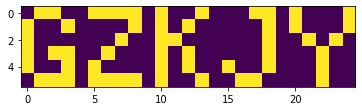

In [7]:
from matplotlib import pyplot as plt
final = img[0]
for layer in img[1:]:
    final = np.where(final < 2, final, layer)
plt.imshow(final)

## day 9: intcode (relative base mode)

In [368]:
### day 9 part 1

import pandas
from collections import namedtuple
Operation = namedtuple('Operation', 'name code num_operands fn')

class Program(object):
    def __init__(self, p):
        self.program = {}
        for i, b in enumerate(p):
            self.program[i] = b
    def get(self, i):
        try:
            return self.program[i]
        except KeyError:
            self.program[i] = 0
            return 0
    def set(self, i, val):
#         logging.info('writing %d to %d', val, i)
        self.program[i] = val
        return val

class IntCode(object):
    def __init__(self, operations, program, inputs, stop_on_output=False):
        self.executed = []
        self.operations = operations
        self.program = Program(program)
        self.ptr = 0
        self.input = inputs
        self.output = None
        self.stop_on_output = stop_on_output
        self.relbase = 0
#         logging.info('program is %d long, supported operations (%s)', len(program), ','.join(['{0}:{1}'.format(op.name, op.code) for op in operations.values()]))
        self.parse_next_operation()
        
    def parse_next_operation(self):
        op = self.program.get(self.ptr)
        self.operation = self.operations[op % 100]
        self.modes = [(op // (10 ** (2 + i))) % 10 for i in range(self.operation.num_operands)]
        self.operands = [self.program.get(x) for x in range(self.ptr + 1, self.ptr + self.operation.num_operands + 1)]
        self.ptr_moved = False
    
    def modify_relbase(self, i):
        self.relbase += i
        return self.relbase
#         logging.info('relbase is now %d', self.relbase)
        
    def get(self, i):
        if self.modes[i] == 0:
            # position mode
            return self.program.get(self.operands[i])
        elif self.modes[i] == 1:
            # immediate mode
            return self.operands[i]
        elif self.modes[i] == 2:
            # rel mode
            return self.program.get(self.operands[i] + self.relbase)
        else:
            raise Exception('bad mode', self.modes)
    
    def set(self, i, value):
#         logger.info('setting %d to %d', self.operands[i], value)
        if self.modes[i] == 0:
            return self.program.set(self.operands[i], value)
        elif self.modes[i] == 2:
            return self.program.set(self.operands[i] + self.relbase, value)
        else:
            raise Exception('bad mode for set', self.modes)
        
    def set_ptr(self, value):
        self.ptr = value
        self.ptr_moved = True
        
    def step(self):
#         logger.info('executing %s %s %s', self.operation.name, self.operands, self.modes)
        self.executed.append({
            "operation": self.operation.name,
            "ptr": self.ptr,
            "operands": self.operands,
            "modes": self.modes,
            "result": self.operation.fn(self)
        })
        if not self.ptr_moved:
            self.ptr += self.operation.num_operands + 1
#             logger.info('ptr is now at %d', self.ptr)
        self.parse_next_operation()
        
    def run_with_input(self, i):
        self.input.append(i)
        return self.run()
        
    def run(self):
        self.output = None
        while self.operation.name != 'exit':
            self.step()
            if self.output is not None:
                logger.info('program output %d', self.output)
                print('OUTPUT', self.output)
                if self.stop_on_output:
                    return self.output
        logger.info('program exited normally')
        self.executed.append({
            "operation": self.operation.name,
            "ptr": self.ptr,
            "operands": self.operands,
            "modes": self.modes,
            "result": self.output
        })
        
    @property
    def execution_df(self):
        return pandas.DataFrame(self.executed)

operations = {}
def add_operation(op):
    operations[op.code] = op
add_operation(Operation('add', 1, 3, lambda i: i.set(2, i.get(0) + i.get(1))))
add_operation(Operation('multiply', 2, 3, lambda i: i.set(2, i.get(0) * i.get(1))))
add_operation(Operation('input', 3, 1, lambda i: i.set(0, i.input.pop(0))))
def output_op(i):
    i.output = i.get(0)
    return i.output
add_operation(Operation('output', 4, 1, output_op))
def jmp_if_true(i):
    if i.get(0) != 0:
        i.set_ptr(i.get(1))
    return i.ptr
def jmp_if_false(i):
    if i.get(0) == 0:
        i.set_ptr(i.get(1))
    return i.ptr
add_operation(Operation('jump-if-true', 5, 2, jmp_if_true))
add_operation(Operation('jump-if-true', 6, 2, jmp_if_false))
add_operation(Operation('less-than', 7, 3, lambda i: i.set(2, 1 if i.get(0) < i.get(1) else 0)) )
add_operation(Operation('equals', 8, 3, lambda i: i.set(2, 1 if i.get(0) == i.get(1) else 0)))
add_operation(Operation('relbase', 9, 1, lambda i: i.modify_relbase(i.get(0))))
add_operation(Operation('exit', 99, 0, None))

program = [int(x) for x in get_input(9).decode('ascii').split(',')]
i = IntCode(operations, program[:], [])
i.run_with_input(1)

INFO:root:program output 2738720997
INFO:root:program exited normally


OUTPUT 2738720997


In [336]:
# day 9 part 2
i = IntCode(operations, program[:], [])
i.run_with_input(2)

INFO:root:program output 50894
INFO:root:program exited normally


OUTPUT 50894


In [360]:
df = i.execution_df
df[df.index < 5]

operation  ptr                  operands      modes            result
0      multiply    0  [34463338, 34463338, 63]  [1, 1, 0]  1187721666102244
1     less-than    4        [63, 34463338, 63]  [0, 1, 0]                 0
2  jump-if-true    8                  [63, 53]     [0, 1]                 8
3      multiply   11              [3, 1, 1000]  [1, 1, 0]                 3
4       relbase   15                     [988]        [1]               988

## day 10: asteroid laser

In [443]:
%%time
### day 10 part 1 (original)

field = list(input_lines(10, convert_fn=lambda x: x))
def is_asteroid(x, y):
    return field[y][x] == '#'
w = len(field[0])
h = len(field)
asteroids = set()
for x in range(w):
    for y in range(h):
        if is_asteroid(x, y):
            asteroids.add((x, y))
asteroids

def isBetween(a, b, c):
    (ax, ay) = a
    (bx, by) = b
    (cx, cy) = c
    crossproduct = (cy - ay) * (bx - ax) - (cx - ax) * (by - ay)

    # compare versus epsilon for floating point values, or != 0 if using integers
    if abs(crossproduct) != 0:
        return False

    dotproduct = (cx - ax) * (bx - ax) + (cy - ay)*(by - ay)
    if dotproduct < 0:
        return False

    squaredlengthba = (bx - ax)*(bx - ax) + (by - ay)*(by - ay)
    if dotproduct > squaredlengthba:
        return False

    return True

m = 0
mloc = (0, 0)

def clear_los(p0, p1):
    for a in asteroids:        
        if a != p1 and a != p0 and isBetween(p0, p1, a):
#             print(a, 'is between', p0, p1)
            return False
#     print('clear', p0, p1)
    return True

def count_los(x, y):
    count = 0
    for (xx, yy) in asteroids:
        if clear_los((x, y), (xx, yy)):
            count += 1
#     print(count, (x, y))
    return count

for x in range(w):
    for y in range(h):
        if is_asteroid(x, y):
            c = count_los(x, y)
            if c > m:
                m = c
                mloc = (x, y)

print('part 1', m, mloc)

INFO:root:fetching http://adventofcode.com/2019/day/10/input
INFO:root:Fetched 930 bytes of input


part 1 286 (22, 25)
CPU times: user 18.6 s, sys: 39.9 ms, total: 18.6 s
Wall time: 20.7 s


In [315]:
### day 10 part 2 (original)
import math
station = mloc
(sx, sy) = station

info = []
for a in asteroids:
    (ax, ay) = a
#     deg = ((math.degrees(math.atan2(ay - sy, ax - sx)) - 90 + 360) % 360)
    deg = (math.degrees(math.atan2(ay - sy, ax - sx)) + 90) % 360
    dist = math.sqrt((ax - sx)**2 + (ay - sy)**2)
    if a != (sx, sy):
        info.append({
            'angle': deg,
            'dist': dist,
            'loc': a
        })
#         if a in [(23, 0), (22, 21)]:
#             print('ANGLE', deg)
    
s = sorted(info, key=lambda x: (x['angle'], x['dist']))
last = None
laser = 0
counter = 0
while counter <= 200:
    ass = s[laser]
    if 'blasted' not in ass and (last is None or ass['angle'] != last['angle']):
#         logging.info('blast %s', ass)
        # blast this one
        ass['blasted'] = True
        counter += 1
        if counter == 200:
            print(ass)
            break
        last = ass        
    laser += 1
    if laser == len(s):
        laser = 0

{'angle': 321.00900595749454, 'dist': 27.018512172212592, 'loc': (5, 4), 'blasted': True}


In [465]:
### day 10 "cleaned" but slower (boo)
%%time
import math
import pandas as pd
from collections import namedtuple  
Point = namedtuple('Point', 'x y')

### from stackoverflow
def distance(a, b):
    return math.sqrt((a.x - b.x)**2 + (a.y - b.y)**2)

def is_between(a,c,b):
    return distance(a,c) + distance(c,b) == distance(a,b)     

# heaps faster...
def isBetween(a, c, b):
    (ax, ay) = a
    (bx, by) = b
    (cx, cy) = c
    crossproduct = (cy - ay) * (bx - ax) - (cx - ax) * (by - ay)

    # compare versus epsilon for floating point values, or != 0 if using integers
    if abs(crossproduct) != 0:
        return False

    dotproduct = (cx - ax) * (bx - ax) + (cy - ay)*(by - ay)
    if dotproduct < 0:
        return False

    squaredlengthba = (bx - ax)*(bx - ax) + (by - ay)*(by - ay)
    if dotproduct > squaredlengthba:
        return False

    return True
                
class AsteroidField(Field):
    def __init__(self, puzzle_input=get_input(10).decode('ascii')):
        super(AsteroidField, self).__init__(puzzle_input)
        self.asteroids = set()
        for point, c in self.iterate():
            if c == '#':
                self.asteroids.add(point)
                
    def can_see(self, src, dst):
        for p in self.asteroids:
            if p == src or p == dst:
                continue
#             elif is_between(Point(*src), Point(*p), Point(*dst)):
            elif isBetween(src, p, dst):
                return False
        return True
    
    def count_in_line_of_sight(self, src):
        count = 0
        for p in self.asteroids:
            if p == src:
                continue
            elif self.can_see(src, p):
                count += 1
#         print(src, count)
        return count
            
a = AsteroidField()
df = pd.DataFrame([[p, a.count_in_line_of_sight(p)] for p, _ in a.iterate()], columns=['point', 'asteroids_in_sight'])
df[df['asteroids_in_sight']==df['asteroids_in_sight'].max()]

CPU times: user 49.2 s, sys: 257 ms, total: 49.4 s
Wall time: 50 s


point  asteroids_in_sight
772  (22, 25)                 286

## day 11: intcode (painting robot)

In [6]:
### day 11 INTCODE AGAIN

import pandas
from collections import namedtuple
Operation = namedtuple('Operation', 'name code num_operands fn')

class Program(object):
    def __init__(self, p):
        self.program = {}
        for i, b in enumerate(p):
            self.program[i] = b
    def get(self, i):
        try:
            return self.program[i]
        except KeyError:
            self.program[i] = 0
            return 0
    def set(self, i, val):
#         logging.info('writing %d to %d', val, i)
        self.program[i] = val
        return val

class IntCode(object):
    def __init__(self, operations, program, inputs, stop_on_output=False):
        self.executed = []
        self.operations = operations
        self.program = Program(program)
        self.ptr = 0
        self.input = inputs
        self.output = None
        self.stop_on_output = stop_on_output
        self.relbase = 0
#         logging.info('program is %d long, supported operations (%s)', len(program), ','.join(['{0}:{1}'.format(op.name, op.code) for op in operations.values()]))
        self.parse_next_operation()
        
    def parse_next_operation(self):
        op = self.program.get(self.ptr)
        self.operation = self.operations[op % 100]
        self.modes = [(op // (10 ** (2 + i))) % 10 for i in range(self.operation.num_operands)]
        self.operands = [self.program.get(x) for x in range(self.ptr + 1, self.ptr + self.operation.num_operands + 1)]
        self.ptr_moved = False
    
    def modify_relbase(self, i):
        self.relbase += i
        return self.relbase
#         logging.info('relbase is now %d', self.relbase)
        
    def get(self, i):
        if self.modes[i] == 0:
            # position mode
            return self.program.get(self.operands[i])
        elif self.modes[i] == 1:
            # immediate mode
            return self.operands[i]
        elif self.modes[i] == 2:
            # rel mode
            return self.program.get(self.operands[i] + self.relbase)
        else:
            raise Exception('bad mode', self.modes)
    
    def set(self, i, value):
#         logger.info('setting %d to %d', self.operands[i], value)
        if self.modes[i] == 0:
            return self.program.set(self.operands[i], value)
        elif self.modes[i] == 2:
            return self.program.set(self.operands[i] + self.relbase, value)
        else:
            raise Exception('bad mode for set', self.modes)
        
    def set_ptr(self, value):
        self.ptr = value
        self.ptr_moved = True
        
    def step(self):
#         logger.info('executing %s %s %s', self.operation.name, self.operands, self.modes)
        self.executed.append({
            "operation": self.operation.name,
            "ptr": self.ptr,
            "operands": self.operands,
            "modes": self.modes,
            "result": self.operation.fn(self)
        })
        if not self.ptr_moved:
            self.ptr += self.operation.num_operands + 1
#             logger.info('ptr is now at %d', self.ptr)
        self.parse_next_operation()
        
    def run_with_input(self, i):
        self.input.append(i)
        return self.run()
    
    def add_input(self, i):
        self.input.append(i)
        
    def run(self):
        self.output = None
        while self.operation.name != 'exit':
            self.step()
            if self.output is not None:
#                 logger.info('program output %d', self.output)
#                 print('OUTPUT', self.output)
                if self.stop_on_output:
                    return self.output
        logger.info('program exited normally')
        self.executed.append({
            "operation": self.operation.name,
            "ptr": self.ptr,
            "operands": self.operands,
            "modes": self.modes,
            "result": self.output
        })
        
    @property
    def execution_df(self):
        return pandas.DataFrame(self.executed)

operations = {}
def add_operation(op):
    operations[op.code] = op
add_operation(Operation('add', 1, 3, lambda i: i.set(2, i.get(0) + i.get(1))))
add_operation(Operation('multiply', 2, 3, lambda i: i.set(2, i.get(0) * i.get(1))))
add_operation(Operation('input', 3, 1, lambda i: i.set(0, i.input.pop(0))))
def output_op(i):
    i.output = i.get(0)
    return i.output
add_operation(Operation('output', 4, 1, output_op))
def jmp_if_true(i):
    if i.get(0) != 0:
        i.set_ptr(i.get(1))
    return i.ptr
def jmp_if_false(i):
    if i.get(0) == 0:
        i.set_ptr(i.get(1))
    return i.ptr
add_operation(Operation('jump-if-true', 5, 2, jmp_if_true))
add_operation(Operation('jump-if-true', 6, 2, jmp_if_false))
add_operation(Operation('less-than', 7, 3, lambda i: i.set(2, 1 if i.get(0) < i.get(1) else 0)) )
add_operation(Operation('equals', 8, 3, lambda i: i.set(2, 1 if i.get(0) == i.get(1) else 0)))
add_operation(Operation('relbase', 9, 1, lambda i: i.modify_relbase(i.get(0))))
add_operation(Operation('exit', 99, 0, None))

In [524]:
class Robot(object):
    def __init__(self, program):
        self.intcode = IntCode(operations, program[:], [], stop_on_output=True)
        self.pos = (0, 0)
        self.whites = set()
        self.dir_ptr = 0
        self.painted = set()
        
    def step(self):
        color = self.intcode.run_with_input(int(self.pos in self.whites))
        if color is None:
            return False
        dir_change = self.intcode.run()
        if dir_change is None:
            return False
        
        if color == 0:
            if self.pos in self.whites: # black
                self.whites.remove(self.pos)
        elif color == 1:
            self.whites.add(self.pos)
        else:
            raise Exception('bad color', color)
        if dir_change == 0: # 0 means it should turn left 90 degrees, and 1 means it should turn right 90 degrees.
            self.dir_ptr -= 1
        elif dir_change == 1:
            self.dir_ptr += 1
        else:
            raise Exception('bad dir', dir_change)
        self.dir_ptr %= 4
        self.painted.add(self.pos)
        
        self.move_forward()
        return True
        
    def move_forward(self):
        delta = [
            (0, -1), (1, 0), (0, 1), (-1, 0)
        ][self.dir_ptr]
        self.pos = (self.pos[0] + delta[0], self.pos[1] + delta[1])
        
    def run(self):
        while self.step():
            pass
        
    def plot(self):
        plot_xy_list(r.whites)

In [525]:
### part 1
program = [int(x) for x in get_input(11).decode('ascii').split(',')]
            
r = Robot(program[:])
r.run()
len(r.painted)

INFO:root:program exited normally


1985

INFO:root:program exited normally


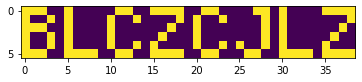

In [528]:
### part 2
r = Robot(program[:])
r.whites.add((0, 0))
r.run()
r.plot()

## day 12: n-body repeat problem

In [51]:
### day 12 part 1
from recordclass import RecordClass
import itertools
import typing
import math

axes = ['x', 'y', 'z']

class Moon(RecordClass):
    pos: dict
    vel: dict
       
    @property
    def energy(self):
        potential = sum(abs(v) for v in self.pos.values())
        kinetic = sum(abs(v) for v in self.vel.values())
        return potential * kinetic

class System(object):
    moons: typing.List[Moon]
    ticks: int
    
    def __init__(self, inp):
        self.moons = []
        self.axis_seen = {
            ax: set() for ax in axes            
        }
        self.axis_repeat = {}
        self.ticks = 0
        for l in inp.split('\n'):
            m = re.search(r'<x=(-?[0-9]+), y=(-?\d+), z=(-?\d+)', l)
            if m is None:
                raise Exception('failed to parse' + l)
            (x, y, z) = m.groups()
            
            self.moons.append(Moon({'x': int(x), 'y': int(y), 'z': int(z)}, {'x': 0, 'y': 0, 'z': 0}))
            
    def tick_gravity(self):
        def adjust_velocity(m0, m1):
            for ax in axes:
                if m0.pos[ax] > m1.pos[ax]:
                    m0.vel[ax] -= 1
                    m1.vel[ax] += 1            
        for m0, m1 in itertools.combinations(self.moons, 2):
            adjust_velocity(m0, m1)
            adjust_velocity(m1, m0)
            
    def tick_velocity(self):
        for m in self.moons:
            for ax in axes:
                m.pos[ax] += m.vel[ax]
    
    def record_seen(self):
        for ax in axes:
            if ax not in self.axis_repeat:
                axis_state = ','.join("{pos}:{vel}".format(pos=m.pos[ax], vel=m.vel[ax]) for m in self.moons)
                if axis_state in self.axis_seen[ax]:
                    self.axis_repeat[ax] = self.ticks
                    print(ax, 'repeats after ', self.ticks)
                else:
                    self.axis_seen[ax].add(axis_state)
    
    def tick(self):
        self.record_seen()
        self.ticks += 1
        self.tick_gravity()
        self.tick_velocity()
        
    def energy(self):
        return sum(m.energy for m in self.moons)
    
    def find_repeat(self):
        while len(self.axis_repeat) != len(axes):
            self.tick()
#             if self.ticks % 10000 == 0:
#                 print('thinking', self.ticks)
        # get the LCM of the 3 numbers
        repeats = list(self.axis_repeat.values())
        lcm = repeats[0]
        for i in repeats[1:]:
            lcm = lcm * i // math.gcd(lcm, i)
        return lcm
                                        
s = System(get_input(12).decode('ascii'))
for t in range(1000):
    s.tick()
s.energy()

8742

In [52]:
%%time
### day 12 part 2
s = System(get_input(12).decode('ascii'))
s.find_repeat()

z repeats after  60424
x repeats after  186028
y repeats after  231614
CPU times: user 6.08 s, sys: 25.9 ms, total: 6.1 s
Wall time: 6.11 s


325433763467176

## day 13: intcode (breakout game)

In [258]:
# day 13 part 1
# every 3rd output is a tile and we want to count 
sum([1 for (i, v) in enumerate(intcode(13).run()) if i % 3 == 2 and v == 2])

207

In [662]:
# day 13 part 1 with numpy practice
import numpy as np
# numpy array slicing: [start:stop:step]
(np.array(intcode(13).run())[2::3] == 2).sum()

INFO:root:program exited normally


207

INFO:root:fetching http://adventofcode.com/2019/day/13/input
INFO:root:Fetched 6406 bytes of input


score 0
move 1000


score 6422
move 2000


score 9356
move 3000


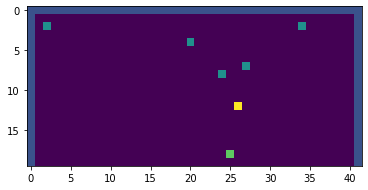

score 9993
move 4000


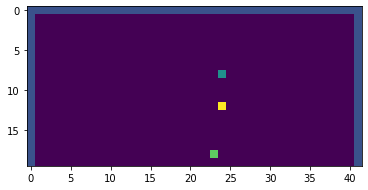

score 10165
move 5000


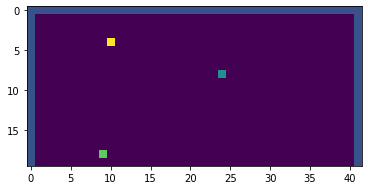

score 10165
final move 5092


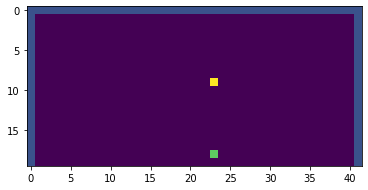

score 10247


10247

In [295]:
# day 13 part 2
# If the joystick is in the neutral position, provide 0.
# If the joystick is tilted to the left, provide -1.
# If the joystick is tilted to the right, provide 1.  
NONE = 0    
LEFT = -1
RIGHT = 1

BLOCK = 2
PADDLE = 3
BALL = 4

class Game:
    def __init__(self, intcode, size):
        self.intcode = intcode
        self.screen = np.full(size, 0).T
        self.score = 0
        
    def tick(self, d=NONE):
        self.ball = -1
        self.paddle = -1
        self.blocks = 0
        self.intcode.outputs = []
        out = self.intcode.run_with_input(d)
        if not out:
            raise Exception('no output from intcode')
        while out:
            (x, y, t) = out[:3]
            out = out[3:]
            if x < 0:
                self.score = t
            else:
                self.screen[y][x] = t
                
            # just record their x positions
            if t == BALL:
                self.ball = x
            elif t == PADDLE:
                self.paddle = x
        self.blocks = (self.screen == 2).sum()

    def plot(self):
        plt.imshow(self.screen)
        plt.show()
        print('score', self.score)
        
    def next_move(self):
        if self.ball > self.paddle:
            # move right
            return RIGHT
        elif self.ball < self.paddle:
            # move left
            return LEFT
        # don't move
        return NONE
    
    def autoplay(self, max_moves=1e6, plot_every=1e3):
        self.tick()
        self.plot()
        moves = 0
        while self.blocks > 0 and moves < max_moves:
            moves += 1
            self.tick(self.next_move())
            if moves % plot_every == 0:
                print('move', moves)
                self.plot()
        print('final move', moves)
        self.plot()

# inefficiently figure out the field size
screen = np.array(intcode(13).run())
w = screen[::3].max() + 1
h = screen[1::3].max() + 1

# run with memory[0] = 2
i = intcode(13)
i.program.set(0, 2)
i.init()
g = Game(i, (w, h))
g.autoplay()
g.score

In [ ]:
%%time
# fun with matplotlib animations
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

i = intcode(13)
i.program.set(0, 2)
i.init()
g = Game(i, (w, h))
g.tick()

fig = plt.figure()
im = plt.imshow(np.copy(g.screen), animated=True)

def updatefig(*args):
    try:
        g.tick(g.next_move())
        im.set_array(np.copy(g.screen))
    except:
        pass
    return im,

ani = animation.FuncAnimation(fig, updatefig, frames=5200, interval=5, blit=True)
HTML(ani.to_html5_video())

dict_keys([(-1, -1), (0, 0), (0, 1), (10, 10), (2, 11)])
10 11 -1 -1


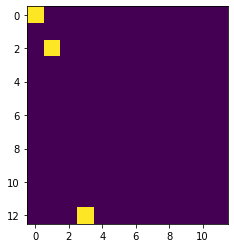

In [66]:
### numpy practice - convert a dict of (x, y) => thing to a numpy array
import numpy as np
def coords_to_numpy(d):
    print(d.keys())
    # first figure out the dimensions
    coords = np.array(list(d.keys()))
    (max_x, max_y) = np.max(coords, axis=0)
    (min_x, min_y) = np.min(coords, axis=0)
    print (max_x, max_y, min_x, min_y)
    width = max_x - min_x + 1
    height = max_y - min_y + 1
    # create a grid of w x h
    grid = np.full((height, width), 0)
    for (x, y) in coords:
        grid[y - min_y][x - min_x] = d[(x, y)]
    return grid
    
d = {
    (-1, -1): 1,
    (0, 0): 0,
    (0, 1): 1,
    (10, 10): 0,
    (2, 11): 1
}
plt.imshow(coords_to_numpy(d))

## day 14: ore-to-fuel conversion

In [35]:
# day 14 part 1
# I totally over-complicated this problem because I thought RHS could produce multiple items - bleugh
# let's try this again
from collections import defaultdict
import math

formulae = get_input(14).decode('ascii').split('\n')
conversions = {}
for f in formulae:
    lhs, rhs = f.split(' => ')
    def parse_resource(r):
        num, thing = r.split(' ')
        return int(num), thing
    num_product, product = parse_resource(rhs)
    inputs = {}
    for x in lhs.split(', '):
        num, thing = parse_resource(x)
        inputs[thing] = num
    conversions[product] = {
        "requires": inputs,
        "num_produced": num_product
    }


def get_required_ore_for(resource, num):
    need = defaultdict(int)
    surplus = {}
    need[resource] = num
    
    while True:
        if 'ORE' in need and len(need) == 1:
            return need['ORE']
        else:
            r = next( k for k in need.keys() if k != 'ORE')
            num = need[r]
            c = conversions[r]
            # how many times do we need to apply?
            times = math.ceil(num / c['num_produced'])
#             print('producing', num, r, 'using', c, times, 'times')
            # we need each of the required inputs x times  
            for req in c['requires']:
                req_num = c['requires'][req] * times
                # consume from surplus first
                if req in surplus:
                    surplus[req] -= req_num
                    req_num = 0
                    if surplus[req] < 0:
                        # not enough
                        req_num = -surplus[req]
                        del surplus[req]
                    elif surplus[req] == 0:
                        del surplus[req]
                need[req] += req_num
            # and produce the full amount
            produced = times * c['num_produced']
            surplus_r = produced - num
            if surplus_r > 0:
                surplus[r] = surplus_r
            del need[r]

get_required_ore_for("FUEL", 1)

220019

In [62]:
# day 14 part 2 - binary chop
target_ore = 1000000000000
# start with some blind guessed values
assert get_required_ore_for("FUEL", 7500000) >= target_ore
assert get_required_ore_for("FUEL", 5000000) <= target_ore

def find_target(upper, lower):
    fuel = (upper + lower) // 2
    ore = get_required_ore_for('FUEL', fuel)
    if ore > target_ore:
        upper = fuel
    elif ore < target_ore:
        lower = fuel
    return upper, lower

upper = 7500000
lower = 5000000
while True:
    upper, lower = find_target(upper, lower)
    if upper <= lower + 1:
        print(lower)
        break

5650230


In [64]:
get_required_ore_for('FUEL', 5650231)

1000000152770

## day 15: maze solver

In [300]:
### day 15 part 1
N = 1
S = 2
W = 3
E = 4

DIR = [
    (),
    (0, -1),
    (0, 1),
    (-1, 0),
    (1, 0)
]

WALL = 0
OK = 1
EXIT = 2

def coords_to_numpy(d):
#     print(d.keys())
    # first figure out the dimensions
    coords = np.array(list(d.keys()))
    (max_x, max_y) = np.max(coords, axis=0)
    (min_x, min_y) = np.min(coords, axis=0)
#     print (max_x, max_y, min_x, min_y)
    width = max_x - min_x + 1
    height = max_y - min_y + 1
    # create a grid of w x h
    grid = np.full((height, width), 0)
    for (x, y) in coords:
        grid[y - min_y][x - min_x] = d[(x, y)]
    return grid


class Maze:
    def __init__(self, intcode):
        self.intcode = intcode
        intcode.stop_on_output = True
        self.pos = (0, 0)
        self.walls = set()
        self.visited = set()
        self.visited.add(self.pos)
        self.exit = None
        self.path = []
        self.facing = N
        self.furthest = 0
        self.longest = None
        
    def get_coord_for_dir(self, d):
        delta = DIR[d]
        return (self.pos[0] + delta[0], self.pos[1] + delta[1])            
    
    def try_move(self, d):
#         print('at', self.pos, 'moving', d)
        result = self.intcode.run_with_input(d)
        n_pos = self.get_coord_for_dir(d)
        if result == WALL:
            self.walls.add(n_pos)
#             print('wall')
            return False
        elif result == EXIT:
            self.pos = n_pos
            self.exit = n_pos
            self.path.append(d)
            if len(self.path) > self.furthest:
                self.furthest = len(self.path)
                self.longest = self.path[:]
            self.visited.add(n_pos)
#             print('exit')
            return True
        else:
            self.pos = n_pos
            self.path.append(d)
            self.visited.add(n_pos)
#             print('ok')
            if len(self.path) > self.furthest:
                self.furthest = len(self.path)
                self.longest = self.path[:]
            return True
        
    def right_of_dir(self, d):
        return [ E, W, N, S ][d-1]
    
    def is_deadend(self):
        for d in [N, S, E, W]: 
            p = self.get_coord_for_dir(d)
            if p not in self.visited and p not in self.walls:
                return False
        return True
    
    def backtrack(self):
#         print('backtracking')
        if len(self.path) == 0:
            return False
        d = self.path.pop()
        inverted_d = [ S, N, E, W ][d-1]
        self.pos = self.get_coord_for_dir(inverted_d)
        res = self.intcode.run_with_input(inverted_d)
        if res != OK:
            # not sure why I'm getting trying to backtrack 1 too many times..?
#             assert res == OK, 'backtrack failed, got ' + str(res) + ' dir ' + str(inverted_d) + str(self.path)
            return False
        return True
        
    def step(self):
        # check that we're not in a deadend (ie. all surroundings visited or walls)
        if self.is_deadend():
            return self.backtrack()
        # check that we haven't visited the tile we are facing
        n_pos = self.get_coord_for_dir(self.facing)
        if n_pos not in self.visited:
            # try move in that direction
            ok = self.try_move(self.facing)
            if ok:
                return True
        # rotate 90 deg
        self.facing = self.right_of_dir(self.facing)
        return True            
        
    @property
    def to_numpy(self):
        data = {}
        for w in self.walls:
            data[w] = 1
        for v in self.visited:
            data[v] = 3
        if self.exit:
            data[self.exit] = 2
        data[(0, 0)] = 4
        data[self.pos] = 5
        return coords_to_numpy(data)
        
    def plot(self):
        plt.imshow(self.to_numpy)
        
    def forget(self):
        # forget everything
        self.visited = set()
        self.visited.add(self.pos)
        self.walls = set()
        self.path = []
        self.furthest = 0
        self.longest = None
        self.facing = N
        
    def solve(self, max_steps=1e5, break_on_exit=True):
        steps = 0
        while self.step():
            steps += 1
            if steps >= max_steps:
                break
            if break_on_exit and self.exit is not None:
                break
        return len(self.path), steps
    
M = Maze(intcode(15))
path, _ = M.solve() # use the "turn-right-on-wall" algorithm until we hit the exit - hope there are no loops!
path

INFO:root:fetching http://adventofcode.com/2019/day/15/input
INFO:root:Fetched 3366 bytes of input


228

In [267]:
M.plot()

starting at oxygen system @ (16, 12)
longest path 348


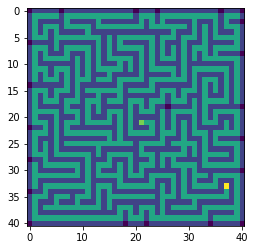

In [255]:
# day 15 part 2
# for the longest time I didn't realise the flood fill starts from the EXIT "the repaired oxgen system" :(
print('starting at oxygen system @', M.pos)
M.forget() # forget all the visited locations and walls so we can crawl the maze again from the exit position
M.solve(break_on_exit=False) # crawl the entire maze to find the furthest path
M.plot() # this should be the complete maze
print('longest path', M.furthest)

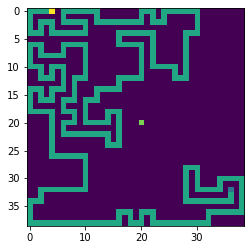

In [256]:
# visualise it
longest_path = M.longest[:]
M.forget()
for d in longest_path:
    assert M.try_move(d) == OK
M.plot()

In [276]:
min(M.walls)

(-21, -20)

In [ ]:
%%time
# animation
# fun with matplotlib animations
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

M = Maze(intcode(15))
_, steps = M.solve() # solve it once to figure out the dimensions
corners = [min(M.walls), max(M.walls)]
M = Maze(intcode(15)) # start from scratch
for w in corners:
    M.walls.add(w) # add the maze corners so we know how big to draw from the start

fig = plt.figure()
im = plt.imshow(np.copy(M.to_numpy), animated=True)

def updatefig(*args):
    if not M.exit:
        M.step()
    im.set_array(np.copy(M.to_numpy))
    return im,

ani = animation.FuncAnimation(fig, updatefig, frames=steps + 100, interval=5, blit=True)
HTML(ani.to_html5_video())

## day 16: stupid maths

In [167]:
%%time
### day 16 part 1

def base(i, b=[0, 1, 0, -1]):
    ptr = 1
    while True:
        offset = (ptr // (i+1)) % 4
        yield b[offset]
        ptr += 1    

def fft_phase(I, n):
    digits = []
    for i in range(len(I)):
        digits.append(abs(sum(a * b for a, b in zip(I, base(i)))) % 10)
    return digits

t = [int(d) for d in list(get_input(16).decode('ascii'))]
print('length', len(t))
for i in range(100):
    t = fft_phase(t, i)
int(''.join(str(s) for s in t[:8]))

length 650
CPU times: user 10.5 s, sys: 19.8 ms, total: 10.5 s
Wall time: 10.5 s


12541048

In [170]:
### day 16 part 2
# ok, bruteforce is NOT going to work, there must be a trick
base_seq=[0, 1, 0, -1]
def get_base_for(nth_row, nth_digit):
    offset = ((nth_digit + 1) // (nth_row + 1)) % 4
    return base_seq[offset]

for y in range(skip, skip+8):
    print([get_base_for(y, x) for x in range(skip, skip+30)])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
# observation:
# for each phase
# the nth digit after such a large skip is basically sum of all the nth input digit to the end of the input
# and the n+1 digit is basically that sum - the nth input digit
# the last digit of the output is basically just the last digit of the input
# so to optimise, we should calculate all the sums starting from the last digit back until the skip offset
# then do mod 10 on each to get the digit for the next round

In [171]:
%%time
input_str = get_input(16).decode('ascii')
I = [int(i) for i in input_str] * 10000
skip = int(input_str[:7])
skipped_I = I[skip:]

def fft_part_2(inp_array):
    out_array = []
    cumulative_sum = 0
    # start from last digit backwards
    for i in range(len(inp_array)-1, -1, -1):
#         print(i)
        cumulative_sum += inp_array[i]
        out_array.append(cumulative_sum % 10)
    return list(reversed(out_array))

t = skipped_I[:]
for i in range(100):
    t = fft_part_2(t)
int(''.join(str(s) for s in t[:8]))

CPU times: user 9.01 s, sys: 277 ms, total: 9.29 s
Wall time: 9.3 s


62858988

## Day 17: IntCode (Sequencing)

INFO:root:Using default key_fn: {'#': 0, '.': 1, '^': 2}


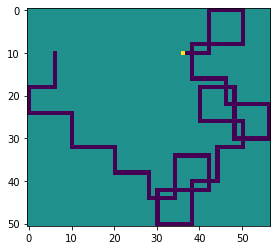

In [368]:
### part 1 using actual code...
# the way I initially did it was run the intcode, paste the output into a text editor
# then replace the intersections by hand with 'x', and find all the coordinates of 'x' via code.
from_ascii_codes = lambda codes: ''.join([chr(c) for c in codes])
output = from_ascii_codes(intcode(17).run())
field = Field(output)
field.plot()

In [369]:
intersections = set()
for (x, y), v in field.iterate(): 
    if v == '#':
        m = Marker((x, y))
        isIntersect = True
        try:
            if all(field.get(x, y) == '#' for (x, y) in m.adjacent()):
                intersections.add((x, y))
                field.add_marker(m)
        except:
            pass
sum(x * y for (x, y) in intersections)

11372

In [370]:
field.plot(key_fn=lambda x: {'#':1,'.':0,'^':2}[x]) # visualising the intersections

INFO:root:Using default key_fn: {'.': 0, '^': 1, 'x': 2}


R6L10R8R8R12L8L8R6L10R8R8R12L8L8L10R6R6L8R6L10R8R8R12L8L8L10R6R6L8R6L10R8L10R6R6L8


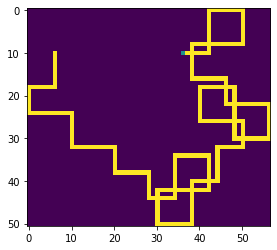

In [371]:
### part 2 was done basically by hand with verification via visualisation
# first give the vacuum the commands and make sure the path is filled correctly

class Vacuum:
    def __init__(self, field):
        self.field = field
        self.marker = Marker(next(field.find('^')), facing=Direction.N)
        
    def move(self, num):
        for i in range(num):
            self.marker.move()
            # mark the location on the field
            self.field.set(self.marker.pos[0], self.marker.pos[1], 'x')
        
    def do_one(self, c):
        if c == 'R':
            self.marker.turn_right()
        elif c == 'L':
            self.marker.turn_left()
        else:
            self.move(int(c))
            
    def execute(self, commands):
        for c in commands:
            self.do_one(c)
    
i = intcode(17)
output = i.run()
field = ''.join([chr(c) for c in output])
output = from_ascii_codes(intcode(17).run())
v = Vacuum(Field(output))
path = [
    'R', 6, 'L', 10, 'R', 8, 'R', 8, 'R', 12, 'L', 8, 'L', 8, 'R', 6, 'L', 10, 'R', 8, 'R', 8, 'R', 12,
    'L', 8, 'L', 8, 'L', 10, 'R', 6, 'R', 6, 'L', 8, 'R', 6, 'L', 10, 'R', 8, 'R', 8, 'R', 12, 'L', 8,
    'L', 8, 'L', 10, 'R', 6, 'R', 6, 'L', 8, 'R', 6, 'L', 10, 'R', 8, 'L', 10, 'R', 6, 'R', 6, 'L', 8
]
v.execute(path)
v.field.plot()
print(''.join(str(x) for x in path))

In [366]:
%%sh
# now we know the correct sequence, I used sed and trial-and-error to figure out the repeated sub-sequences,
# taking care to keep the lengths under 20 bytes... (took me 2 serious tries)
echo R6L10R8R8R12L8L8R6L10R8R8R12L8L8L10R6R6L8R6L10R8R8R12L8L8L10R6R6L8R6L10R8L10R6R6L8 \
| sed 's/R6L10R8/A,/g'

echo R6L10R8R8R12L8L8R6L10R8R8R12L8L8L10R6R6L8R6L10R8R8R12L8L8L10R6R6L8R6L10R8L10R6R6L8 \
| sed 's/R6L10R8/A,/g' \
| sed 's/R8R12L8L8/B,/g'

echo R6L10R8R8R12L8L8R6L10R8R8R12L8L8L10R6R6L8R6L10R8R8R12L8L8L10R6R6L8R6L10R8L10R6R6L8 \
| sed 's/R6L10R8/A,/g' \
| sed 's/R8R12L8L8/B,/g' \
| sed 's/L10R6R6L8/C,/g'

A,R8R12L8L8A,R8R12L8L8L10R6R6L8A,R8R12L8L8L10R6R6L8A,L10R6R6L8
A,B,A,B,L10R6R6L8A,B,L10R6R6L8A,L10R6R6L8
A,B,A,B,C,A,B,C,A,C,


In [372]:
# finally run the intcode with the input - just manually typing it out
def cmd2input(s):
    return [ord(c) for c in s+"\n"] 
commands = [
    'A,B,A,B,C,A,B,C,A,C',
    'R,6,L,10,R,8',
    'R,8,R,12,L,8,L,8',
    'L,10,R,6,R,6,L,8',
    'n'
]
inputs = []
for c in commands:
    for i in cmd2input(c):
        inputs.append(i)
ii = intcode(17)
ii.program.set(0, 2)
ii.init()
ii.inputs = inputs[:]
ii.run()[-1] # get the last output

1155497

## Day 18: Maze with keys/doors (cursed day)
The goal here is to find the shortest path to collect all the keys (marked a-z).

But there are doors (marked A-Z) which can only be passed if the corresponding key has been picked up.

This means a simple graph search is insufficient as the graph "reconfigures" every time a key is picked up.

I was stumped on this day for the longest time because I tried to use `networkx` to quickly do the maze walking but had a bug in my Djikstra-esque implementation where I did not exclude keys that have been picked up from being considered again. I ended up trying to optimise (memoize, find ways to prune search trees) rather than debug which took me down a rabbit hole for the longest time :(

In the end I did part 1 using a step-by-step BFS for part 1 (which worked because I avoided the bug accidentally), and then was stumped when part 2 (which divided the maze into 4 quadrants with a bot in each) made that too computationally expensive.

Eventually I had to look at other solutions and when comparing them to mine I realised there was a bug rather than a lack of optimisations.

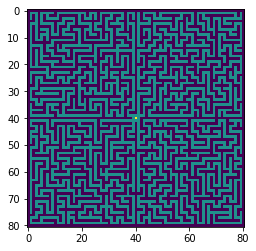

In [297]:
f = Field(get_input(18).decode('ascii'))
f.plot(key_fn=lambda x: 0 if x == '#' else 2 if x == '@' else 1)

In [298]:
%%time
### PART 1: blind BFS approach - pretty slow
# loop all possible next steps
# storing position, keys-in-hand, (and steps taken)
# if a stored position + keys-in-hand is already visited, don't visit again (this is because BFS guarantees earlier visits are cheaper)

from collections import deque, namedtuple

keys = 'abcdefghijklmnopqrstuvwxyz'
doors = keys.upper()

field = Field(get_input(18).decode('ascii'))
start = next(field.find('@'))

State = namedtuple('State', ['pos', 'keys', 'distance'])
queue = deque()
seen = set()

# start with initial state
queue.append(State(start, set(), 0))

while queue:
    s = queue.popleft()
    # get the state without the distance
    key = (s.pos, ''.join(sorted(s.keys)))
    if key in seen:
        continue
    seen.add(key)
#     if len(seen) % 100000 == 0:
#         print(len(seen))
    # is this a valid tile?
    tile = field.get(s.pos[0], s.pos[1])
    if tile == '#' or (tile in doors and tile.lower() not in s.keys):
        continue
    # if this is a key tile, add it
    new_keys = set(s.keys)
    new_distance = s.distance + 1
    if tile in keys:
        new_keys.add(tile)
        if len(new_keys) == len(keys):
            print('SOLUTION', s.distance, 'states considered:', len(seen))
            break
    # try all 4 directions
    m = Marker(s.pos)
    queue.append(State(m.relative_pos(Direction.N), new_keys, new_distance))
    queue.append(State(m.relative_pos(Direction.E), new_keys, new_distance))
    queue.append(State(m.relative_pos(Direction.S), new_keys, new_distance))    
    queue.append(State(m.relative_pos(Direction.W), new_keys, new_distance))    

3862
CPU times: user 1min 24s, sys: 968 ms, total: 1min 25s
Wall time: 1min 26s


### Day 18 part 2 redux

Let's rethink the problem. So we have 4 bots in 4 disconnected sections of the maze; and 26 keys and 26 doors.

Each step a bot picks up one of the accessible keys. We have to find the sequence of keys that gives the shortest path travelled for all bots together.

So the ordered sequence of keys is sufficient to give the current state.

However to optimise calculations we should probably keep track of bot positions instead of deriving them from the keys picked up; and probably pre-calculate the distance from start/key positions to every other key, and the keys necessary to open that path.

We could then treat the bot positions + owned keys as a "node" and use Djikstra's to solve for shortest path to any "node" that possesses all keys:

1. precalculate all key-to-key and start-to-key distances and the keys necessary
    * (!) this approach assumes there are no multiple paths to a key with doors in between...
1. create a priority queue with the initial state of (positions + no keys + 0 distance)
1. create a set of visited states
1. loop until path found
    1. read from the queue the first state (with shortest distance)
    1. if we have visited this state before (same positions of bots, same number of keys), continue
    1. add it to the visited states
    1. for each accessible key from this state that we don't already have - using precalc'd pairs
        1. calculate the new state if we moved to this key (new position + new key + new distance)
        1. if this new state has all keys, report the solution
        1. add the new state to the queue
        
Wasn't this what I tried before though? How is this any better...

**SO...**, a number of bugs I had that caused me not to be able to solve it up to now:
* I didn't exclude trying to pick up a key that I already had as an option, so it basically looped trying to get the same keys over and over
* Then I miscalculated the optimisation where it discards keys that are only reachable by pathing through other keys so that too many options were added (I accidentally put the .append() inside the for k in keys loop)
* Then finally I didn't consider the fact that it _can_ path through another key if it had already been picked up

However, my solution is still substantially slower than some others even if they do BFS-in-BFS :(

In [299]:
%%time
### PART 2: after much travail...
# turns out much faster than part 1...
import networkx as nx

### THIS IS MY FINAL ATTEMPT I SWEAR
# data = '''#################
# #i.G..c...e..H.p#
# ########.########
# #j.A..b...f..D.o#
# ########@########
# #k.E..a...g..B.n#
# ########.########
# #l.F..d...h..C.m#
# #################'''

# data = '''########################
# #...............b.C.D.f#
# #.######################
# #.....@.a.B.c.d.A.e.F.g#
# ########################'''

# data = '''########################
# #f.D.E.e.C.b.A.@.a.B.c.#
# ######################.#
# #d.....................#
# ########################'''

data = get_input(18).decode('ascii')

## field = the modified part 2 maze
field = Field(data)
orig = next(field.find('@'))
field.set(orig[0]-1, orig[1]-1, '@')
field.set(orig[0]-1, orig[1], '#')
field.set(orig[0]-1, orig[1]+1, '@')
field.set(orig[0], orig[1]-1, '#')
field.set(orig[0], orig[1], '#')
field.set(orig[0], orig[1]+1, '#')
field.set(orig[0]+1, orig[1]-1, '@')
field.set(orig[0]+1, orig[1], '#')
field.set(orig[0]+1, orig[1]+1, '@')
## starts = the positions of the bots at start
starts = tuple(field.find('@'))

## keys & doors
uniq_chars = np.unique(field.numpy)
keys = [k for k in uniq_chars.tolist() if re.match(r'[a-z]', k)]
key_pos = { k: next(field.find(k)) for k in keys }
doors = [k for k in uniq_chars.tolist() if re.match(r'[A-Z]', k)]
door_pos = { k: next(field.find(k)) for k in doors }

## G = nx graph of maze with all doors opened
G = nx.grid_2d_graph(field.width, field.height)
for (x, y), v in field.iterate():
    if v == '#':
        G.remove_node((x, y))

## shortest distance between all keys and starting points
import itertools
points_of_interest = dict(key_pos)
for i, pos in enumerate(starts): # treat 0-3 as bot "id"s
    points_of_interest[i] = pos

# invert door pos for lookup
pos_door = { v: k for k, v in door_pos.items() }

from dataclasses import dataclass, field as dcfield
from typing import Any
from queue import PriorityQueue
from collections import defaultdict

@dataclass
class State:
    positions: tuple
    owned_keys: frozenset
    key_seq: list

@dataclass(order=True)
class PrioritizedState:
    distance: int
    state: State=dcfield(compare=False)
    def __hash__(self):
        return hash((self.state.positions, self.state.owned_keys))

@dataclass
class PathToKey:
    source_key: str
    dest_key: str
    dest_pos: tuple
    needed_keys: frozenset
    path_keys: frozenset # if you take this path you will pick up these keys on the way, only consider this path if you don't have every key here
    distance: int
        
## precalc all positions to keys
pos_to_path = defaultdict(list)
for p0, p1 in itertools.combinations(points_of_interest, 2):
    pos0 = points_of_interest[p0]
    pos1 = points_of_interest[p1]
    # use networkx to figure out the shortest path for us
    try:
        path = nx.shortest_path(G, pos0, pos1)
        # don't add this path if the path crosses any other keys (since it would be more optimal to pick that key up first)
        path_keys = frozenset([k for k in keys if k != p0 and k != p1 and key_pos[k] in path])
        need_keys = frozenset([ pos_door[p].lower() for p in path if p in pos_door ])
        if p1 not in range(4):
            pos_to_path[pos0].append(PathToKey(p0, p1, pos1, need_keys, path_keys, len(path)-1))
        if p0 not in range(4):
            pos_to_path[pos1].append(PathToKey(p1, p0, pos0, need_keys, path_keys, len(path)-1))
    except nx.NetworkXNoPath:
        pass
    
## state = positions: tuple((x, y), ..), owned_keys: tuple(sorted(keys)), distance: int
def get_next_states(pstate):
    for i, pos in enumerate(pstate.state.positions):
        for path in pos_to_path[pos]:
            # check that this isn't a key I have already
            # and check if I have the keys needed
            # and check if I already have all the keys in the path to this dest_key
            if (not path.dest_key in pstate.state.owned_keys) and (pstate.state.owned_keys & path.needed_keys == path.needed_keys) and (pstate.state.owned_keys & path.path_keys == path.path_keys):
                # construct the new state
                new_positions = list(pstate.state.positions[:])
                new_positions[i] = path.dest_pos
                new_distance = pstate.distance + path.distance
                new_keys = pstate.state.owned_keys | frozenset([path.dest_key])
                new_seq = pstate.state.key_seq[:]
                new_seq.append(path.dest_key)
                yield PrioritizedState(new_distance, State(tuple(new_positions), new_keys, new_seq))

queue = PriorityQueue()
visited = set()

initial = PrioritizedState(0, State(starts, frozenset(), []))
queue.put(initial)

while True:
    if queue.empty():
        print('ERROR empty queue')
        break
    s = queue.get()
    if s in visited:
        continue
    visited.add(s)
#     if len(visited) % 10000 == 0:
#         print(len(visited), s)
    if len(s.state.owned_keys) == len(keys):
        print('SOLVED', s.distance)
        break
    for ns in get_next_states(s):
        queue.put(ns)
        
### FINALLY
### HALLELUJAH

SOLVED 1626
CPU times: user 7.68 s, sys: 51.9 ms, total: 7.73 s
Wall time: 7.75 s


## Day 19: tractor beam

In [285]:
## optimise repeatedly getting pixels for testing
@lru_cache(maxsize=None)
def get_xy(x, y):
    i = intcode(19)
    i.inputs.append(x)
    i.inputs.append(y)
    out = i.run()
    return out

CPU times: user 5.35 s, sys: 11.6 ms, total: 5.37 s
Wall time: 5.38 s


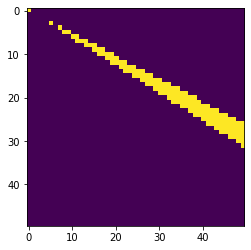

In [286]:
%%time

### part 1
coords = {}
n = 0
h = 50
w = 50
m = np.full((h, w), 0)
for y in range(h):
    for x in range(w):
        m[y][x] = get_xy(x, y)[0]
m.sum()
plt.imshow(m)

In [287]:
### part 2 fugly - can't be bothered to clean up
def solve_from(x, y):
    xchecks = [
        (x + 100 - 1, y),
        (x + 100, y)
    ]
    ychecks = [
        (x, y + 100 -1),
        (x, y + 100)
    ]
    xcr = [get_xy(xc[0], xc[1])[0] for xc in xchecks]
    ycr = [get_xy(yc[0], yc[1])[0] for yc in ychecks]
    if xcr == [0, 0]: # need to move down
        return (x, y + 1)
    if ycr == [0, 0]: # need to move right
        return (x + 1, y)
    return None

n = (0, 0)
c = 0
while True:
    c += 1
    if c % 1000 == 0:
        print(c, n)
    nn = solve_from(n[0], n[1])
    if not nn:
        print(n, 10000 * n[0] + n[1])
        break
    n = nn

1000 (620, 379)
2000 (1276, 723)
(1353, 764) 13530764


In [181]:
%%time
_,E,F,M=set,enumerate,filter,{}
U=lambda x:_(F(str.islower,x))
for y,r in E(get_input(18).decode('ascii').split('\n')):
 for x,c in E(r):M[x+y*1j]=c
L=lambda:{c:x for x,c in M.items()}
c=L()['@']
for y,o in zip((-1j,0,1j),("0#1","###","2#3")):
 for x,o in zip((-1,0,1),o):M[c+x+y]=o
L=L();W={x for x,c in M.items()if'#'==c}
B,K,D,C=list("0123"),U(L),{},{}
for k in _(B)|K:
 n={L[k]};f={};d=0;v=_(W);D[k]={}
 while n:
  c=n;n=_();v|=c
  for p in c:
   r={p-1j,p+1j,p-1,p+1}-v;n|=r
   for x in r:f[x]=p
 for j in K:
  v=_();d=0;p=L[j]
  while p in f:v|={M[p]};p=f[p];d+=1
  D[k][j]=(j,d,U(v),_(map(str.lower,F(str.isupper,v))))
def S(v,p,d):
 if v==K:return d
 z=tuple(sorted(v)+p)
 if z in C:return C[z]+d
 s=min(min([1e9]+[S(v|g,[t if q==u else q for q in p],a)for t,a,g,n in(D[u][t]for t in K-v)if not(n-v)and a])for i,u in E(p));C[z]=s;return s+d
print(S(_(),B,0))

1626
CPU times: user 404 ms, sys: 3.12 ms, total: 407 ms
Wall time: 408 ms


## Day 20: Maze with portals

In [174]:
### part 1

import collections
import networkx as nx

letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

def find_portals():
    portals = {}
    portal_pos = collections.defaultdict(set)
    for (x, y), v in f.iterate():
        if v in letters:
            m = Marker((x, y))
            loc = None
            pair = None
            got = []
            for i, a in enumerate(m.adjacent()):
                try:
                    c = f.get(a[0], a[1])
                    got.append((a, c))
                except:
                    c = None
                    got.append((a, c))
                if c and c in letters:
                    if i == Direction.N or i == Direction.W:
                        pair = c + v
                    else:
                        pair = v + c
                if c == '.':
                    loc = a
            if loc:
                if not pair:
                    print('failed to get pair for', (x, y), v, got)
                portals[loc] = pair
                portal_pos[pair].add(loc)
    return portals, portal_pos

f = Field(get_input(20).decode('ascii'))

# portals: (x, y) => AA
# portal_pos: AA => set((x, y))
portals, portal_pos = find_portals()

# construct the usual networkx graph for the maze
G = nx.grid_2d_graph(f.width, f.height)
for (x, y), v in f.iterate():
    if v != '.':
        G.remove_node((x, y))
        
# connect up the portals
for port in portal_pos:
    if len(portal_pos[port]) == 2:
        pos0, pos1 = portal_pos[port]
        G.add_edge(pos0, pos1)

# use nx to solve for us        
start = list(portal_pos['AA'])[0]
goal = list(portal_pos['ZZ'])[0]        
        
nx.shortest_path_length(G, start, goal)

482

In [343]:
%%time
### part 2 BFS again x_x
import collections
import itertools
from dataclasses import dataclass, field as dcfield
from typing import Any
from queue import PriorityQueue
from collections import defaultdict

data = get_input(20).decode('ascii')
f = Field(data)

letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
def find_portals():
    portals = {}
    portal_pos = collections.defaultdict(set)
    for (x, y), v in f.iterate():
        if v in letters:
            m = Marker((x, y))
            loc = None
            pair = None
            got = []
            for i, a in enumerate(m.adjacent()):
                try:
                    c = f.get(a[0], a[1])
                    got.append((a, c))
                except:
                    c = None
                    got.append((a, c))
                if c and c in letters:
                    if i == Direction.N or i == Direction.W:
                        pair = c + v
                    else:
                        pair = v + c
                if c == '.':
                    loc = a
            if loc:
                if not pair:
                    print('failed to get pair for', (x, y), v, got)
                portals[loc] = pair
                portal_pos[pair].add(loc)
    return portals, portal_pos
            
portals, portal_pos = find_portals()

def is_outer_portal(pos):
    return pos[0] == 2 or pos[1] == 2 or pos[0] == (f.width - 3) or pos[1] == (f.height - 3)

# create a mapping of the 2 ends of portals
portal_exit = {}
for port in portal_pos:
    if len(portal_pos[port]) == 2:
        pos0, pos1 = portal_pos[port]
        portal_exit[pos0] = pos1
        portal_exit[pos1] = pos0
    else:
        pos0, = portal_pos[port]
        portal_exit[pos0] = pos0
portal_exit

# recreate the graph without portals
G = nx.grid_2d_graph(f.width, f.height)
for (x, y), v in f.iterate():
    if v != '.':
        G.remove_node((x, y))

# construct a dict of all the reachable portals/goal from every other portal/start
# reachable: (x, y) => (dest: (x, y), dest_key, distance, level_change)
reachable = collections.defaultdict(list)
for pos0, pos1 in itertools.combinations(portals.keys(), 2):
    try:
        d = nx.shortest_path_length(G, pos0, pos1)
        if portals[pos1] != 'AA':
            reachable[pos0].append((pos1, portals[pos1], d, -1 if is_outer_portal(pos1) else 1))
        if portals[pos0] != 'AA':
            reachable[pos1].append((pos0, portals[pos0], d, -1 if is_outer_portal(pos0) else 1))
    except nx.NetworkXNoPath:
        pass    

@dataclass
class State:
    position: tuple
    level: int
    path: list

@dataclass(order=True)
class PrioritizedState:
    distance: int
    state: State=dcfield(compare=False)
    def __hash__(self):
        return hash((self.state.position, self.state.level))
    
def get_next_states(pstate):
    d, state = pstate.distance, pstate.state
    if state.level < 0: # prune if we're going negative
        return []
    for dest_loc, dest, dist, lvl_change in reachable[state.position]:
        if dest == 'ZZ' and state.level != 0: # skip 'ZZ' unless we are on level 0
            continue
        if state.level + lvl_change < 0 and dest != 'ZZ':
            continue
        # teleport to the new portal exit
        new_path = state.path[:]
        new_path.append((state.level, "%s[%s]==%d steps==>%s:%s[%s]" % (state.position, portals[state.position], dist, dest_loc, portal_exit[dest_loc], dest)))
        
        yield PrioritizedState(d + dist + 1, State(portal_exit[dest_loc], state.level + lvl_change, new_path))

queue = PriorityQueue()
visited = set()

initial = PrioritizedState(0, State(start, 0, []))
queue.put(initial)

while True:    
    if queue.empty():
        raise Exception('empty queue')
    s = queue.get()
    if s in visited:
        continue
    visited.add(s)
    if len(visited) % 50000 == 0:
        print(len(visited), s)
    if s.state.position == goal:
        if s.state.level == -1:
            print('SOLUTION:', s.distance - 1) # -1 since we don't count walking into ZZ
            break
        else:
            continue
    for ns in get_next_states(s):

        
        queue.put(ns)

SOLUTION: 5912
CPU times: user 1.18 s, sys: 34.5 ms, total: 1.21 s
Wall time: 1.25 s


In [342]:
%%time
import networkx as nx
max_levels = 30

# create the Field
f = Field(get_input(20).decode('ascii'))

# create a baze maze with the paths
base_maze = f.nx_maze(is_wall_fn=lambda x: x != '.')

# create max_levels copies of the base maze but with the level attached to each node
recursive_maze = nx.Graph()
for l in range(max_levels):
    for edge in base_maze.edges():
        n0, n1 = edge
        recursive_maze.add_edge((n0, l), (n1, l))
    
# reuse our find_portals function
_, portal_pos = find_portals()
start = list(portal_pos['AA'])[0]
goal = list(portal_pos['ZZ'])[0]

# connect up the portal pairs
for portal in portal_pos:
    if len(portal_pos[portal]) == 2:
        pos0, pos1 = portal_pos[portal]
        for l in range(max_levels - 1):
            if is_outer_portal(pos1): # assuming every portal has an inner/outer pair
                # XF inner, 0 goes to XF outer, 1
                recursive_maze.add_edge((pos0, l), (pos1, l + 1))           
            else:
                recursive_maze.add_edge((pos1, l), (pos0, l + 1))

# then just solve!
nx.shortest_path_length(recursive_maze, (start, 0), (goal, 0))

CPU times: user 735 ms, sys: 6.45 ms, total: 741 ms
Wall time: 745 ms


5912

In [442]:
# consider implementing a generalised dijkstras algorithm where you only need to implement
# (i) a State object that is hashable
# (ii) a get_next_states(priority, state) function that returns another list of (priority, state)
# (iii) a is_solved(state) function that returns boolean
# and run with solve(initial_state) to return lowest 
from queue import PriorityQueue
from dataclasses import dataclass, field as dcfield
from typing import Any, Callable, Generator

@dataclass(order=True)
class PrioritizedState:
    distance: int
    state: Any=dcfield(compare=False)
    def __hash__(self):
        return hash(self.state)

def dijkstra(initial_state: PrioritizedState, 
             get_next: Callable[[PrioritizedState], Generator[PrioritizedState, None, None]], 
             is_solved: Callable[[PrioritizedState], bool]) -> Generator[PrioritizedState, None, None]:
    queue = PriorityQueue()
    visited = set()
    queue.put(PrioritizedState(0, initial_state))
    
    while True:
        if queue.empty():
            logging.warning('no more states to try')
            break
        ps = queue.get()
        if ps in visited:
            continue
        visited.add(ps)
        if is_solved(ps):
            logging.info('solution found after visitng %d', len(visited))
            yield ps
        for ns in get_next(ps):
            queue.put(ns)

In [426]:
## consider the simple BFS of a maze
from mazelib import Maze
from mazelib.generate.AldousBroder import AldousBroder
m = Maze()
m.generator = AldousBroder(30, 30)
m.generate()
m.generate_entrances()
f = Field(m.tostring(True))
f.plot()

INFO:root:Using default key_fn: {' ': 0, '#': 1, 'E': 2, 'S': 3}


INFO:root:solution found after visitng 88835
INFO:root:Using default key_fn: {' ': 0, '#': 1, '*': 2, 'E': 3, 'S': 4}


CPU times: user 12.9 s, sys: 129 ms, total: 13 s
Wall time: 13.2 s


314

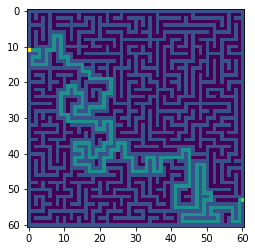

In [436]:
%%time
start = next(f.find('S'))
goal = next(f.find('E'))

## the state is just the position of the robot
@dataclass
class State:
    position: tuple
    path: list
    def __hash__(self):
        return hash(self.position)

## get_next returns all the adjacent positions which are not walls
def get_next(p: PrioritizedState):
    m = Marker(p.state.position)
    for a in m.adjacent():
        try:
            if f.get(*a) != '#':
                path = p.state.path[:]
                path.append(a)
                yield PrioritizedState(1 + p.distance, State(a, path))
        except KeyError:
            pass
        
## get solved state is if position is at goal
def is_solved(p: PrioritizedState):
    return p.state.position == goal

solution = next(dijkstra(State(start, []), get_next, is_solved))
for p in solution.state.path:
    if p != goal:
        f.set(*p, '*')
    
f.plot()
solution.distance

In [438]:
%%time
# versus networkx
nx.shortest_path_len(f.nx_maze(), start, goal))

CPU times: user 30.3 ms, sys: 752 µs, total: 31.1 ms
Wall time: 30.4 ms


315

## Day 21: IntCode + SpringCode (boolean logic programming)

In [762]:
### part 1
# jump distance is ...# 
# jump when 0001
# 0001 J
# 0010 gg
# 0011 J
# 0100 gg
# 0101 J
# 0110 gg
# 0111 J
# 1000 no J
# 1001 J
# 1010 no J
# 1011 J
# 1100 no J
# 1101 J
# 1110 no J
# 1111 no J

# D must be 1
# A or B or C is 0
# (NOT A OR NOT B OR NOT C) AND D

i = intcode(21)
i.add_ascii_commands('''OR A T
AND B T
AND C T
NOT T J
AND D J
WALK''')
i.run()[-1]

19361850

In [766]:
### part 2, jump when it is a hole at E and H
commands = '''OR A T
AND B T
AND C T
NOT T J
AND D J
OR E T
OR H T
AND T J
RUN'''

i = intcode(21)
i.add_ascii_commands(commands)
i.run()[-1]

1138943788

## Day 22: Number Theory :wat:

In [735]:
### part 1
import re
size = 10007
deck = range(size)

for l in input_lines(22):
    m = re.search(r'deal with increment (\d+)', l)
    if m:
        n = int(m.group(1))
        nn = 0
        d2 = [0] * size
        for c in deck:
            d2[nn] = c
            nn += n
            nn %= size
        deck = d2 
        continue
    m = re.search(r'cut (-?\d+)', l)
    if m:
        n = int(m.group(1))
        if n > 0:
            top, bot = deck[0:n], deck[n:]
            deck = list(bot) + list(top)
        elif n < 0:
            top, bot = deck[0:n], deck[n:]
            deck = list(bot) + list(top)
        continue
    if l == 'deal into new stack':
        deck = list(reversed(deck))
        continue
    raise Exception('failed to parse ' + l)
        
deck.index(2019)

2939

In [ ]:
# function version
# size = size of deck
# pos = position in deck
# val = current value
def deal_new(size, pos, val):
    return size - val

def cut_n(size, pos, val, n):
    return (val + n) % size

def deal_inc(size, pos, val, n):
    # the value of the card will be the value of the card at position (-pos * n) % size

In [643]:
## ok so this requires learning a bit of number theory, which I don't have the capacity to do right now
# - I cheated and looked at other solutions
# what we want to do is translate the whole sequence of shuffle operations into a function F, such that
# F(x) returns the x-th card in the deck after shuffling once from the factory sequence [0..max]
# the operations ought to be combinable
# deal new:          F(x) => size - x - 1
# cut N:          F(x, n) => (x + n) % size
# deal increment: F(x, n) => (-x * n) % size   <-- this is the one I don't know how to combine
x = sympy.Symbol('x', integer=True)
size = 10
y = (-x * 3) % size
[ y.subs(x, c) for c in range(10) ]

[0, 7, 4, 1, 8, 5, 2, 9, 6, 3]

In [737]:
import sympy
import re

# stolen from reddit
def modinv(a, m):
    m0 = m
    y = 0
    x = 1
    if m == 1:
        return 0
    while a > 1:
        # q is quotient
        q = a // m
        t = m
        # m is remainder now, process
        # same as Euclid's algo
        m = a % m
        a = t
        t = y
        # Update x and y
        y = x - q * y
        x = t
    # Make x positive
    if x < 0:
        x = x + m0
    return x

class Shuffler:
    def __init__(self, instructions, deck_size):
        self.deck_size = deck_size
        if isinstance(instructions, str):
            instructions = instructions.split('\n')

        self.x = sympy.Symbol('x', integer=True)
        self.expr = self.x

        for i in reversed(instructions):
            self.parse(i)
            
        self.fn = sympy.simplify(self.expr % self.deck_size)
        
    def parse(self, i):
        m = re.match(r'cut (-?\d+)', i)
        if m:
            n = int(m.group(1))
            self.expr += n
            return
        if i == 'deal into new stack':
            self.expr = self.deck_size - 1 - self.expr
            return
        m = re.match(r'deal with increment (\d+)', i)
        if m:
            n = int(m.group(1))
#             self.expr = (-self.expr * n) % self.deck_size # this doesn't work
            self.expr = self.expr * modinv(n, self.deck_size)    
            return
        raise KeyError('Failed to parse ' + i)
        
    def run(self, deck=None):
        if not deck:
            deck = range(self.deck_size)
        return [self.fn.subs(self.x, c) for c in deck]


s = Shuffler(get_input(22).decode('ascii'), 10007)

# check the function works with 10007 case
assert s.run().index(2019) == 2939
s.fn

Mod(54781364163597346387220817567836758129763048578508507132616450937187258104810337075010159108121376258611340366273536191172943061990126090462067041710899200000000000*x + 4134, 10007)

In [738]:
deck_size = 119315717514047
s = Shuffler(get_input(22).decode('ascii'), deck_size)
# now we have the shuffle operation as a function F(x) = ax + b where (a, b) are massive numbers
# we just need to work out mathematically how to run this function the ridiculous times we need to shuffle for
s.fn

Mod(64701337022060343820226393583070349434634307926694491961597553874086667241858882805974964927526696341879184859440299872225838381081016011205767500567133993486371913753517642027543653238974053108178007527810720946448672170703287188397881081098463537817926311407053629833397998496748246747377408422900706248412225246788376129398970815623890514469506475268175585405666624882104420028439898015321116879607429441244694150213491370243179289017439287966745941270399968386095768818703624996367576619856050403303885870024957315735095874708801656287179783817532077624936961664426785781467129097523999172632191696896000000000*x + 89398771567475, 119315717514047)

In [739]:
# for example, after 1 shuffle, the card at 2020 would be
s.fn.subs(s.x, 2020) % s.deck_size

117599454398659

In [733]:
# how do we reduce N shuffles into a single formula?
#    f(x) = ax + b
# f(f(x)) = a(ax + b) + b
#         = a^2 x + ab + b
# ...     = a^2 (ax + b) + ab + b
#         = a^3 x + a^2 b + ab + b
# ...     = a^N x + (a^(N-1) + a^(N-2) + ... + 1) * b
# apparently, it reduces down to
#         = a^N x + (a^N - 1) / (a - 1) * b
a = 64701337022060343820226393583070349434634307926694491961597553874086667241858882805974964927526696341879184859440299872225838381081016011205767500567133993486371913753517642027543653238974053108178007527810720946448672170703287188397881081098463537817926311407053629833397998496748246747377408422900706248412225246788376129398970815623890514469506475268175585405666624882104420028439898015321116879607429441244694150213491370243179289017439287966745941270399968386095768818703624996367576619856050403303885870024957315735095874708801656287179783817532077624936961664426785781467129097523999172632191696896000000000
b = 89398771567475
x = 2020
m = deck_size
N = 101741582076661 # number of shuffles
# since we have all the variables, we just need to plug them in
# We use power mod instead and modinverse to divide since we're doing a mod at the end otherwise the numbers will get huge
(pow(a, N, m) * x + b * (pow(a, N, m) - 1) * modinv(a - 1, m)) % m

45347150615590

## Day 23: IntCode (Network Interfaces)

In [10]:
# pretty easy today, but the wording is just confusing
nics = [intcode(23) for i in range(50)]
for i, n in enumerate(nics):
    n.add_input(i)
    n.add_input(-1)

nat = None
yvalues = set()
while True:
    idle = True
    for i, n in enumerate(nics):
        if n.waiting_for_input:
            n.add_input(-1)
        outputs = n.run()
        if len(outputs) > 0:
            idle = False
        while len(outputs):
            dst, x, y = outputs[:3]
            outputs = outputs[3:]
            if dst == 255:
                if nat is None:
                    print('part 1:', y)
                nat = (x, y)
            else:
                nics[dst].add_input(x)
                nics[dst].add_input(y)
    if idle:
        nics[0].add_input(nat[0])
        nics[0].add_input(nat[1])
        if nat[1] in yvalues:
            print('part 2:', nat[1])
            break
        yvalues.add(nat[1])

part 1: 15662
part 2: 10854


## day 24: recursive Game of Life

In [917]:
data = get_input(24).decode('ascii')
field = Field(data)
field.plot()

INFO:root:fetching http://adventofcode.com/2019/day/24/input
INFO:root:Fetched 30 bytes of input
INFO:root:Using default key_fn: {'#': 0, '.': 1}


In [919]:
### part 1
# I screwed up coding the if/then/else here for some reason for the longest time, forgetting that I needed to
# copy the existing value into the 'else' case if the other 2 conditions were not satisfied
def loop(field):
    s = ''
    new_field = field.clone()
    for (x,y), v in field.iterate():
        m = Marker((x, y))
        bugs = 0        
        for a in m.adjacent():
            try:
                if field.get(a[0], a[1]) == '#':
                    bugs += 1
            except KeyError:
                pass
        if v == '#' and bugs != 1:
            new_field.set(x, y, '.')
        elif v == '.' and (bugs == 1 or bugs == 2):
            new_field.set(x, y, '#')
        else:
            new_field.set(x, y, v)
    return new_field

fields = set()
data = get_input(24).decode('ascii')
field = Field(data)
while True:
    if field.raw in fields:
        break
    fields.add(field.raw)
    field = loop(field)
    
field.plot()

n = 0
rating = 0
for _, v in field.iterate():
    if v == '#':
        rating += (2 ** n)        
    n += 1
rating

INFO:root:Using default key_fn: {'#': 0, '.': 1}


18370591

In [911]:
### part 2
# I spent waaay too long trying to come up with a smart way to only creating and calculating the N-th or -N-th
# recursion depth when necessary but in the end the simple "create 200 levels straight off the bat" worked fine 
# and would've been a lot quicker dev time had I started with that
class Level:
    # each level is a 5x5 grid
    def __init__(self, up = None, down = None, new_recurse = False, depth=0):
        self.field = Field('\n'.join(['.' * 5] * 5))
        self._new = new_recurse
        self._down = down
        self._up = up
        self.depth = depth
        
    def count_bugs_on_edge(self, d):
        if d == Direction.N:
            return sum([self.field.get(x, 0) == '#' for x in range(5)])
        if d == Direction.S:
            return sum([self.field.get(x, 4) == '#' for x in range(5)])
        if d == Direction.E:
            return sum([self.field.get(4, y) == '#' for y in range(5)])
        if d == Direction.W:
            return sum([self.field.get(0, y) == '#' for y in range(5)])
        raise NotImplementedError

    @property
    def down(self):
        if self._down is None:
            self._down = Level(up=self, new_recurse=True, depth=self.depth + 1)
        return self._down
    
    @property
    def up(self):
        if self._up is None:
            self._up = Level(down=self, new_recurse=True, depth=self.depth - 1)
        return self._up
    
    def count_adj_bugs(self, pos):
        if pos == (2, 2):
            raise KeyError('cannot count middle cell')
        m = Marker(pos)
        bugs = 0
        for ax, ay in m.adjacent():
            if (ax, ay) == (2, 2):
                if pos == (2, 1):
                    bugs += self.down.count_bugs_on_edge(Direction.N)
                elif pos == (3, 2):
                    bugs += self.down.count_bugs_on_edge(Direction.E)
                elif pos == (2, 3):
                    bugs += self.down.count_bugs_on_edge(Direction.S)
                elif pos == (1, 2):
                    bugs += self.down.count_bugs_on_edge(Direction.W)
                else:
                    raise KeyError('wrong adjacency code?')
            try:
                v = self.field.get(ax, ay)
                if v == '#':
                    bugs += 1
            except KeyError:
                if self.up:
                    if ax == -1:
                        bugs += 1 if self.up.field.get(1, 2) == '#' else 0
                    if ay == -1:
                        bugs += 1 if self.up.field.get(2, 1) == '#' else 0
                    if ax == 5:
                        bugs += 1 if self.up.field.get(3, 2) == '#' else 0
                    if ay == 5:
                        bugs += 1 if self.up.field.get(2, 3) == '#' else 0
        return bugs
    
    def _next_field(self):
        new_field = self.field.clone()
        for (x, y), v in self.field.iterate():
            if (x, y) == (2, 2):
                new_field.set(2, 2, 'R')
                continue
            bugs = self.count_adj_bugs((x, y))
            if v == '#' and bugs != 1:
                new_field.set(x, y, '.')
            elif v == '.' and (bugs == 1 or bugs == 2):
                new_field.set(x, y, '#')
            else:
                new_field.set(x, y, v) # unchanged
        return new_field
    
    def count_this_level(self):
        return sum([c == '#' for c in self.field.raw])

    def tick(self, max_depth=20):
        # calculate
        next_fields = {} # level => field
        if self.depth != 0:
            assert False
        next_fields[0] = self._next_field()
        up = self._up
        while up is not None:
            next_fields[up.depth] = up._next_field()
            if abs(up.depth) >= max_depth:
                up = None
            else:
                up = up._up
        down = self._down
        while down is not None:
            next_fields[down.depth] = down._next_field()
            if abs(down.depth) >= max_depth:
                down = None
            else:
                down = down._down
        
        # apply
        self.field = next_fields[0]
        count = self.count_this_level()
        up = self._up
        while up is not None and up.depth in next_fields:
            up.field = next_fields[up.depth]
            count += up.count_this_level()
            up = up._up
        down = self._down
        while down is not None and down.depth in next_fields:
            down.field = next_fields[down.depth]
            count += down.count_this_level()
            down = down._down    
        return count

CPU times: user 21.2 s, sys: 93.8 ms, total: 21.3 s
Wall time: 21.5 s


2040

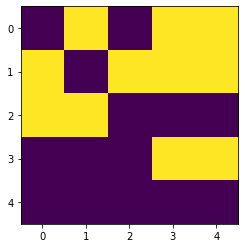

In [921]:
%%time
field = Field(get_input(24).decode('ascii'))
l = Level()
l.field = field
for i in range(200):
    bugs = l.tick(200)
    
l.field.plot(key_fn=lambda x: 1 if x == '#' else 0)
bugs

## Day 25: Interactive Fiction

What I ended up doing was creating an interactive version, walking the maze and picking up all possible items (that don't lead to game over), and then storing those commands to reach the checkpoint, and then trying every possible permutation of items until the right weight was found. Originally done using a terminal rather than jupyter.

In [936]:
## interactive version that returns commands executed
i = intcode(25, output_ascii=True)
commands = []
while True:
    print(i.run())
    I = input()
    if I == 'q':
        break
    commands.append(I)
    i.add_ascii_commands(I)
commands




== Hull Breach ==
You got in through a hole in the floor here. To keep your ship from also freezing, the hole has been sealed.

Doors here lead:
- east
- south
- west

Command?

east



== Gift Wrapping Center ==
How else do you wrap presents on the go?

Doors here lead:
- west

Items here:
- weather machine

Command?

take weather machine

You take the weather machine.

Command?

west



== Hull Breach ==
You got in through a hole in the floor here. To keep your ship from also freezing, the hole has been sealed.

Doors here lead:
- east
- south
- west

Command?

south



== Warp Drive Maintenance ==
It appears to be working normally.

Doors here lead:
- north
- south

Items here:
- photons

Command?

south



== Science Lab ==
You see evidence here of prototype polymer design work.

Doors here lead:
- north

Command?

north



== Warp Drive Maintenance ==
It appears to be working normally.

Doors here lead:
- north
- south

Items here:
- photons

Command?

north



== Hull Breach =

['east',
 'take weather machine',
 'west',
 'south',
 'south',
 'north',
 'north',
 'west',
 'west',
 'take bowl of rice',
 'east',
 'north',
 'east',
 'take hypercube',
 'south',
 'take dark matter',
 'north',
 'west',
 'take polygon',
 'north',
 'take candy cane',
 'west',
 'west',
 'north',
 'take dehydrated water',
 'west',
 'south']

In [934]:
%%time
import itertools

## these were generated from interactively playing the game
items = ['weather machine', 'bowl of rice', 'hypercube', 'dark matter', 'polygon', 'candy cane', 'dehydrated water']
init_commands = ['east', 'take weather machine', 'west', 'south', 'south', 'north', 'north', 'west', 'west', 'take bowl of rice', 'east', 'north', 'east', 'take hypercube', 'south', 'take dark matter', 'west', 'east', 'north', 'west', 'take polygon', 'north', 'take candy cane', 'north', 'south', 'west', 'west', 'north', 'take dehydrated water', 'west', 'south']

# first walk to the checkpoint picking up all items
i = intcode(25, output_ascii=True)
i.add_ascii_commands(init_commands)

for num_items in range(len(items)):
    solved = False
    for p in itertools.combinations(items, num_items):
        # blindly take/drop items we want
        try_commands = []
        for item in items:
            if item in p:
                try_commands.append('take %s' % item)
            else:
                try_commands.append('drop %s' % item)
        i.add_ascii_commands(try_commands)
        i.add_ascii_commands('south') # enter the checkpoint
        o = i.run()
        if 'Droids on this ship are' not in o:
            print('SOLVED')
            print('\n'.join(o.split('\n')[-5:]))
            solved = True
            break
    if solved:
        break

SOLVED

A loud, robotic voice says "Analysis complete! You may proceed." and you enter the cockpit.
Santa notices your small droid, looks puzzled for a moment, realizes what has happened, and radios your ship directly.
"Oh, hello! You should be able to get in by typing 10504192 on the keypad at the main airlock."

CPU times: user 17.2 s, sys: 54.2 ms, total: 17.3 s
Wall time: 17.6 s
